# Probando en otros niveles de OTU
En este script lo que vamos a ver es el mejor modelo en diferentes niveles taxonomicos cogiendo los datos que solo tienen los OTUs que se dan al menos en el 80% de los samples

# Parte comun

In [1]:
#importamos paquetes
import sys
sys.path.append('Src/')
from data_modificado import * #hay funciones que estan cambiadas en este script para adaptralas a nuestro dataset
from train_2 import * #este hubo que modificar una linea tambien
from transfer_learning import * #hubo que modificart lo mismo que en train_2
from transfer_learning_FI import * #necesario para el Feature Importance
from test_functions import *
from layers import *
from utils import *
from loss import *
from metric import *
from results import *
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
import itertools as it

#funciones
def read_df(
              metadata_names=['age','Temperature','Precipitation3Days'],
              random_state=42,
              otu_filename='../Datasets/otu_table_all_80.csv',
              metadata_filename='../Datasets/metadata_table_all_80.csv'):
    otu = pd.read_csv(otu_filename, index_col=0, header=None).T
    #print(otu.head())
    otu = otu.set_index('otuids')
    otu = otu.astype('int32')
    metadata = pd.read_csv(metadata_filename)
    #print(metadata.head())
    metadata = metadata.set_index('X.SampleID')
    metadata.head()
    domain = metadata[metadata_names]
    #if 'INBREDS' in metadata_names:
    #    domain = pd.concat([domain, pd.get_dummies(domain['INBREDS'], prefix='INBREDS')], axis=1)
    #    domain = domain.drop(['INBREDS'], axis=1)
    #elif 'Maize_Line' in metadata_names:
    #    domain = pd.concat([domain, pd.get_dummies(domain['Maize_Line'], prefix='Maize_Line')], axis=1)
    #    domain = domain.drop(['Maize_Line'], axis=1) 
    df = pd.concat([otu, domain], axis=1, sort=True, join='outer')
    #print(df.head())
    #data_microbioma = df[otu.columns].to_numpy(dtype=np.float32)
    #data_domain = df[domain.columns].to_numpy(dtype=np.float32)
    df_microbioma = df[otu.columns]
    df_domain = df[domain.columns]
    df_domain.head()
    df_microbioma_train, df_microbioma_no_train, df_domain_train, df_domain_no_train = \
        train_test_split(df_microbioma, df_domain, test_size=0.1, random_state=random_state)
    # Transfer learning subset
    df_microbioma_test, df_microbioma_transfer_learning, df_domain_test, df_domain_transfer_learning = \
        train_test_split(df_microbioma_no_train, df_domain_no_train, test_size=0.1, random_state=random_state)
    df_microbioma_transfer_learning_train, df_microbioma_transfer_learning_test, df_domain_transfer_learning_train, df_domain_transfer_learning_test = \
        train_test_split(df_microbioma_transfer_learning, df_domain_transfer_learning, test_size=0.3, random_state=random_state)
    
    return df_microbioma_train, df_microbioma_test, df_microbioma_transfer_learning_train, df_microbioma_transfer_learning_test, df_domain_train, df_domain_test, df_domain_transfer_learning_train, df_domain_transfer_learning_test, otu.columns, domain.columns
    #return df_microbioma_train, df_microbioma_test, df_microbioma_transfer_learning_train, df_microbioma_transfer_learning_test, df_domain_train, df_domain_test, df_domain_transfer_learning_train, df_domain_transfer_learning_test, otu.columns, domain.columns


def train_kfold_mod(model_fn, m_train, d_train, z_train, m_test, d_test, z_test,
                batch_size, epochs, train_callbacks):
    all_models = model_fn()
    model, encoder_bioma, encoder_domain, decoder_bioma = all_models
    metrics_prefix = None
    if encoder_bioma is not None and encoder_domain is not None:
        x_train = (m_train, d_train)
        y_train = (m_train, m_train, z_train)
        x_test = (m_test, d_test)
        y_test = (m_test, m_test, z_test)
    elif encoder_bioma is not None:
        x_train = m_train
        y_train = m_train
        x_test = m_test
        y_test = m_test
        metrics_prefix = 'bioma'
    elif encoder_domain is not None:
        x_train = d_train
        y_train = m_train
        x_test = d_test
        y_test = m_test
        metrics_prefix = 'domain'

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(5000).batch(
        batch_size)
    train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
    val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
    val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)
    r = model.fit(train_dataset,
                  epochs=epochs,
                  validation_data=val_dataset,
                  callbacks=train_callbacks,
                  verbose=0)
    if metrics_prefix is not None:
        old_keys = r.history
        r.history = {}
        for k, v in old_keys.items():
            if k == 'loss' or k == 'val_loss':
                new_key = k
            elif k.startswith('val_'):
                new_key = 'val_{}_{}'.format(metrics_prefix, k[4:])
            else:
                new_key = '{}_{}'.format(metrics_prefix, k)
            r.history[new_key] = v
    del val_dataset
    del train_dataset
    del x_train
    del y_train
    del x_test
    del y_test
    return r, all_models

def train_2(model_fn,
          data_microbioma,
          data_domain,
          latent_space=10,
          folds=5,
          epochs=20,
          batch_size=128,
          learning_rate_scheduler=ExpDecayScheluder(),
          random_seed=347,
          verbose=0):
    data_zeros_latent = np.zeros((data_microbioma.shape[0], latent_space), dtype=data_microbioma.dtype)
    results = []
    models = []
    train_callbacks = [
        callbacks.EarlyStopping(monitor='val_loss', patience=epochs + 1, restore_best_weights=True)]
    if verbose >= 0:
        train_callbacks += [TqdmCallback(verbose=verbose)]
    if learning_rate_scheduler is not None:
        train_callbacks += [learning_rate_scheduler.make()]

    if folds <= 1:
        m_train, m_test = data_microbioma, data_microbioma
        d_train, d_test = data_domain, data_domain
        z_train, z_test = data_zeros_latent, data_zeros_latent
        tf.random.set_seed(random_seed)
        r, m = train_kfold(model_fn, m_train, d_train, z_train, m_test, d_test, z_test,
                           batch_size, epochs, train_callbacks)
        results.append(r)
        models.append(m)

    else: #EL PROBLEMA ESTA AQUI, QUE HACE FALTA UN 
        kf = KFold(n_splits=folds, random_state=random_seed, shuffle=True)
        tf.random.set_seed(random_seed)

        for train_index, test_index in kf.split(data_microbioma):
            m_train, m_test = data_microbioma[train_index], data_microbioma[test_index]
            #print(m_train)
            #d_train, d_test = data_domain[train_index], data_domain[test_index]
            if data_domain is None:
                d_train, d_test = None, None
            else:
                d_train, d_test = data_domain[train_index], data_domain[test_index]
            #print(d_train)
            #Esto de hacer el if else ha funcionado, pero no se si hace lo que debe bien
            z_train, z_test = data_zeros_latent[train_index], data_zeros_latent[test_index]
            r, m = train_kfold_mod(model_fn, m_train, d_train, z_train, m_test, d_test, z_test,
                               batch_size, epochs, train_callbacks)
            results.append(r)
            models.append(m)
    return results, models

def perform_experiment_2_mod(cv_folds, epochs, batch_size, learning_rate, optimizer,
                       learning_rate_scheduler, input_transform, output_transform,
                       reconstruction_loss, latent_space, layers,
                       activation, activation_latent,
                       data_microbioma_train, data_domain_train,
                       show_results=True, device='/CPU:0'): #Show results cambiado de False  aTrue
    if input_transform is not None:
        input_transform = input_transform()
    #----------    
    if output_transform is not None:
        output_transform = output_transform()
    #----------      
    if reconstruction_loss.__class__.__name__ == 'MakeLoss':
        reconstruction_loss = reconstruction_loss.make()
    else:
        reconstruction_loss = reconstruction_loss()
    domain_layers = [l // 16 for l in layers] ####que es esto???? Esto es para las capas del domain
    #print(domain_layers)
    bioma_autoencoder = " -> ".join(["b"] +
                                    [str(l) for l in layers] +
                                    [str(latent_space)] +
                                    [str(l) for l in reversed(layers)] +
                                    ["b"])
    #---------- 
    #esto solo se utiliza para el texto, es irrelevante para nuestro error
    if data_domain_train is not None:
        domain_autoencoder = " -> ".join(["d"] +
                                     [str(l) for l in domain_layers] +
                                     [str(latent_space)] +
                                     [str(l) for l in reversed(layers)] +
                                     ["b"])
        
    else: 
        domain_autoencoder = " "
    #---------- 
    #donde se usa domain autoencoder?
    in_transform_name = input_transform.__class__.__name__ if input_transform else "none"
    out_transform_name = output_transform.__class__.__name__ if output_transform else "none"
    lr_scheduler_text = learning_rate_scheduler[
        1] if learning_rate_scheduler is not None else "none"
    lr_text = learning_rate if learning_rate_scheduler is not None else "constant = {}".format(
        learning_rate)
    learning_rate_scheduler = learning_rate_scheduler[
        0] if learning_rate_scheduler is not None else None
    optimizer = optimizer(learning_rate=learning_rate)
    #---------- 
    experiment_parameters = [
        ("Input transform", in_transform_name),
        ("Output transform", out_transform_name),
        ("Reconstruction Loss", reconstruction_loss.__class__.__name__),
        ("Latent Space", latent_space),
        ("Bioma Autoencoder", bioma_autoencoder),
        ("Domain Autoencoder", domain_autoencoder),
        ("Activation Encoder", activation),
        ("Activation Decoder", activation),
        ("Activation Latent", activation_latent),
        ("CV folds", cv_folds),
        ("Epochs", epochs),
        ("Batch Size", batch_size),
        ("Learning Rate Scheduler", lr_scheduler_text),
        ("Learning Rate", lr_text),
        ("Optimizer", optimizer.__class__.__name__),
    ]
    #----------  
    if show_results:
        md_text = ""
        md_text += "| Parameter             | Value         |\n"
        md_text += "|:----------------------|:--------------|\n"
        for n, v in experiment_parameters:
            md_text += "| {} | {} |\n".format(n, v)

        display(Markdown(md_text))
    #------------
    def create_model(print_data=False):
        bioma_shape=data_microbioma_train.shape[1]
        
        if data_domain_train is not None:
            domain_shape=data_domain_train.shape[1]
            #print("data_domain_train!=None")
        else:
            domain_shape=None
            #print("data_domain_train==None")
        models = autoencoder(bioma_shape=bioma_shape,
                             #bioma_shape=717,
                             domain_shape=domain_shape,
                             output_shape=bioma_shape,
                             #output_shape=717,
                             latent_space=latent_space,
                             bioma_layers=layers, #Esto es lo de [512,316]
                             domain_layers=domain_layers, #Esto son cada una de las layers divididas por 16
                             input_transform=input_transform,
                             output_transform=output_transform,
                             activation_function_encoder=activation,
                             activation_function_decoder=activation,
                             activation_function_latent=activation_latent)
        #Entiendo analizando lo demas que aqui NO esta el error
        #la funcion autoencoder esta en model.py (es la unica funcion en ese script)
        
        model, encoder_bioma, encoder_domain, decoder_bioma = models

        if print_data:
            plot_models(model, encoder_bioma, encoder_domain, decoder_bioma)
        compile_train(model,
                      encoder_bioma=encoder_bioma,
                      encoder_domain=encoder_domain,
                      reconstruction_error=reconstruction_loss,
                      encoded_comparison_error=losses.MeanAbsoluteError(),
                      metrics=get_experiment_metrics(input_transform, output_transform),
                      optimizer=optimizer)
        
        #print("He acabado create_model :)")
        return model, encoder_bioma, encoder_domain, decoder_bioma
    #-----------
    create_model(print_data=False)
    #-----------
    #Esta en esta seccion el problema, en train_2
    #print(data_domain_train)
    #print(latent_space)
    with tf.device(device):
        results, models = train_2(create_model,
                                data_microbioma_train,
                                data_domain_train,
                                latent_space=latent_space,
                                folds=cv_folds,
                                epochs=epochs,
                                batch_size=batch_size,
                                learning_rate_scheduler=learning_rate_scheduler,
                                verbose=-1)
    #----------
    validation_results = print_results(results, show_results=show_results)
    if show_results:
        display(Markdown("*************"))

    return experiment_parameters + validation_results, models, results

--------------------
Estas funciones comunes seran para guardar los datos y ver su error_per_OTU

In [2]:
##Creo que esto es comun, por lo que no hay que pasarlo a todas
def save_predicted_otu_table_and_latent(pred,pred_latent,sample_names,otu_names,suffix=''):
    df_otu = pd.DataFrame(pred, index=sample_names, columns=otu_names)
    df_otu.T.to_csv('datos_especiales/resultados/otus_'+suffix+'.tsv', index=True, header=True, sep='\t')

    df_latent = pd.DataFrame(pred_latent, index=sample_names)
    df_latent.T.to_csv('datos_especiales/resultados/latent_'+suffix+'.tsv', index=True, sep='\t')
    
    return df_otu, df_latent

#Compute metrics by OTU
# Absolute abundance transformed to TSS (with epsilon=1E-6)
def transform_to_rel_abundance(dataset):
    epsilon=1E-6
    sum_per_sample = dataset.sum(axis=1)
    num_samples = sum_per_sample.shape
    num_OTUs = np.shape(dataset)[-1] 
    sum_per_sample = sum_per_sample + (num_OTUs * epsilon)
    dividend=dataset+epsilon
    dataset_rel_abund = np.divide(dividend,sum_per_sample[:,None])
    #display(Markdown("{}</p>".format(np.array2string(actual_array,precision=6,floatmode='fixed'))))
    #actual_array.sum(axis=1)
    return dataset_rel_abund
def compute_relative_squared_error(actual,pred):
    rse_otu=np.zeros(actual.shape[1],dtype=np.float32)
    actual=actual_array.transpose()
    pred=pred_domain.transpose()
    # for each OTU
    for i, (act_otu,pred_otu) in enumerate(zip(actual,pred)):
        mean_otu = act_otu.mean()
        #display(Markdown("{} (mean(act)): {}</p>".format(i,mean_otu)))
        #display(Markdown("{} (act): {}</p>".format(i,np.array2string(act_otu,precision=8,floatmode='fixed'))))
        #display(Markdown("{} (pred): {}</p>".format(i,np.array2string(pred_otu,precision=8,floatmode='fixed'))))
        div_up=((pred_otu-act_otu)**2).sum()
        div_down=((pred_otu-mean_otu)**2).sum()
        rse_otu[i]=div_up/div_down
    return rse_otu, np.sqrt(rse_otu)

def save_errors_per_OTU(RSE,RRSE,otu_names,suffix=''):
    df_RSE = pd.DataFrame(RSE, index=otu_names, columns=['RSE'])
    df_RRSE = pd.DataFrame(RRSE, index=otu_names, columns=['RRSE'])
    df_error = df_RSE.join(df_RRSE)
    df_error.to_csv(suffix+'.tsv', index=True, header=True, sep='\t')
    
    return df_error

Funcion para sacar la feature Importance en cada uno de los modelos

In [3]:
def FI(): ##Hay que tener cuidado cuando se ejecute esto
    metric_results, _ = test_model_tl_noEnsemble_FI(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)
    error_original = metric_results["BrayCurtis"][0]
    metricas = dict()
    for i, variable in enumerate(nombres_metadatos):
        #print(variable)
        df1 = df_domain_test
        valores_BrayCurtis = []
        for j in range(0,10,1): #para sacar la desviacion tipica de cada uno
            #print(j)
            #shuffleamos la variable
            df1[variable] = np.random.permutation(df_domain_test[variable].values)
            data_domain_test_nueva = df1.to_numpy()
            #hacemos el modelo
            metric_results, _ = test_model_tl_noEnsemble_FI(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test_nueva)
            #valores_BrayCurtis.append(metric_results["BrayCurtis"][0]/error_original)
            valores_BrayCurtis.append(metric_results["BrayCurtis"][0]-error_original)#cualquiera de la dos, tanto division como resta vale, pero esta me parece mas facil de comparar
        metricas[variable] = valores_BrayCurtis
    return metricas

------------------
Esta funcion es solo para estos datos, porque no hay que separarlos, ya estan separados en train y test

In [4]:
def read_df_especiales(
              metadata_names=['age','Temperature','Precipitation3Days'],
              random_state=42,
              otu_filename='../Datasets/otu_table_all_80.csv',
              metadata_filename='../Datasets/metadata_table_all_80.csv'):
    otu = pd.read_csv(otu_filename, index_col=0, header=None).T
    #print(otu.head())
    otu = otu.set_index('otuids')
    otu = otu.astype('int32')
    metadata = pd.read_csv(metadata_filename)
    #print(metadata.head())
    metadata = metadata.set_index('X.SampleID')
    metadata.head()
    domain = metadata[metadata_names]
    #if 'INBREDS' in metadata_names:
    #    domain = pd.concat([domain, pd.get_dummies(domain['INBREDS'], prefix='INBREDS')], axis=1)
    #    domain = domain.drop(['INBREDS'], axis=1)
    #elif 'Maize_Line' in metadata_names:
    #    domain = pd.concat([domain, pd.get_dummies(domain['Maize_Line'], prefix='Maize_Line')], axis=1)
    #    domain = domain.drop(['Maize_Line'], axis=1) 
    df = pd.concat([otu, domain], axis=1, sort=True, join='outer')
    #print(df.head())
    #data_microbioma = df[otu.columns].to_numpy(dtype=np.float32)
    #data_domain = df[domain.columns].to_numpy(dtype=np.float32)
    df_microbioma = df[otu.columns]
    df_domain = df[domain.columns]
    df_domain.head()
    
    
    return df_microbioma, df_domain, otu.columns, domain.columns
    #return df_microbioma_train, df_microbioma_test, df_microbioma_transfer_learning_train, df_microbioma_transfer_learning_test, df_domain_train, df_domain_test, df_domain_transfer_learning_train, df_domain_transfer_learning_test, otu.columns, domain.columns



--------------------------
# Latent OTU

### Genus

In [5]:
#Cargamos los datos
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ['F_TOTAL', 'V_TOTAL', 'V_REDOR_TOTAL', 'V_STARCHY_TOTAL', 'V_LEGUMES', 'G_TOTAL', 'PF_TOTAL', 'PF_MEAT', 'PF_CUREDMEAT', 'PF_ORGAN', 'PF_POULT',\
					'PF_SEAFD_HI', 'PF_SEAFD_LOW', 'PF_EGGS', 'PF_SOY', 'PF_NUTSDS', 'D_TOTAL', 'D_YOGURT', 'OILS', 'SOLID_FATS', 'ADD_SUGARS', 'A_DRINKS']
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/nuevos_datos/arreglados/otu_table_Genus.csv',metadata_filename='datos-remoto/comidas/metadatos_comidas.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder |   |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 96 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>93</b></p>

<b>loss</b>: 0.0767 (min: 0.0767, max: 0.0767)

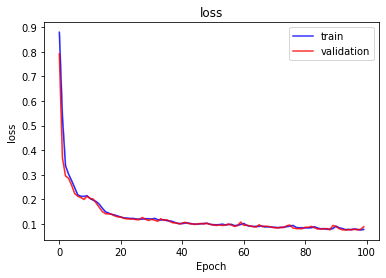

<b>bioma_mse</b>: 0.0000 (min: 0.0000, max: 0.0000)

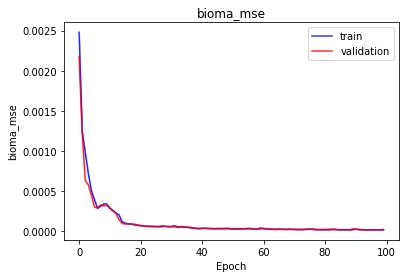

<b>bioma_mae</b>: 0.0009 (min: 0.0009, max: 0.0009)

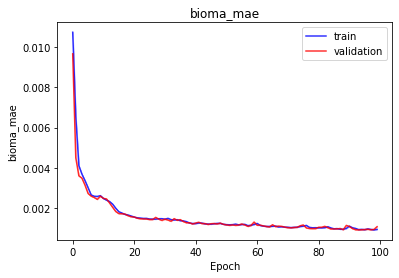

<b>bioma_mape</b>: 1899.7953 (min: 1899.7953, max: 1899.7953)

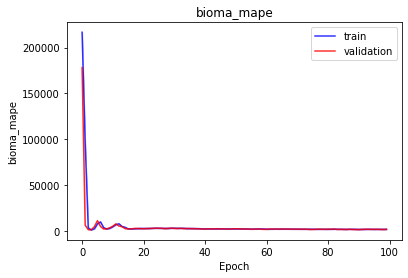

<b>bioma_BrayCurtis</b>: 0.0767 (min: 0.0767, max: 0.0767)

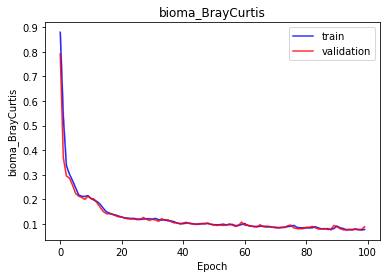

<b>bioma_pearson_corr</b>: 0.9958 (min: 0.9958, max: 0.9958)

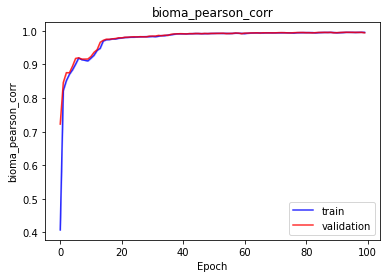

<b>bioma_jensen_shannon_divergence</b>: 0.1299 (min: 0.1299, max: 0.1299)

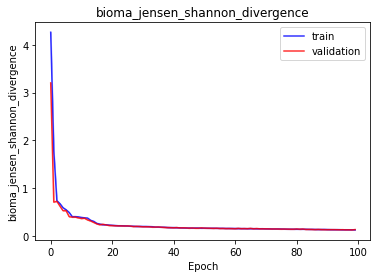

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.07672604421774547 | 0.07672604421774547 | 0.07672604421774547 |
| bioma_mse | 1.7871856471174397e-05 | 1.7871856471174397e-05 | 1.7871856471174397e-05 |
| bioma_mae | 0.0009357602102681994 | 0.0009357602102681994 | 0.0009357602102681994 |
| bioma_mape | 1899.7952880859375 | 1899.7952880859375 | 1899.7952880859375 |
| bioma_BrayCurtis | 0.0767260491847992 | 0.0767260491847992 | 0.0767260491847992 |
| bioma_pearson_corr | 0.9958096742630005 | 0.9958096742630005 | 0.9958096742630005 |
| bioma_jensen_shannon_divergence | 0.1298564374446869 | 0.1298564374446869 | 0.1298564374446869 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.2768424153327942 | 0.2768424153327942 | 0.2768424153327942 |
| pearson_corr | 0.8796001076698303 | 0.8796001076698303 | 0.8796001076698303 |
| jensen_shannon_divergence | 0.4984849691390991 | 0.4984849691390991 | 0.4984849691390991 |


In [6]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=96,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=None,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='sigmoid')(in_layer)
    net = layers.Dense(64, activation='sigmoid')(net)
    net = layers.Dense(32, activation='sigmoid')(net)
    net = layers.Dense(16, activation='sigmoid')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

In [7]:
encoder_biome = encoder
encoder_domain = model_latent
#Guardamos las predicciones
df_microbioma_test.T.to_csv('Results/comida/genero/otus_original_test_OTUcomidaFiltrada_genero.tsv', index=True, header=True, sep='\t')

#run prediction test set from microbiome, i.e, reconstructed
# Input only domain (i.e. environmental features)
pred_latent_biome = encoder_biome.predict(data_microbioma_test)
pred_biome = decoder.predict(pred_latent_biome)

_, _ = save_predicted_otu_table_and_latent(pred_biome,pred_latent_biome,df_microbioma_test.index,df_microbioma_test.columns,'reconstAEfromBiome_OTUcomidaFiltrada_genero')

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_domain_test)
pred_domain = decoder.predict(pred_latent)
df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,df_microbioma_test.index,df_microbioma_test.columns,'predFromDomain_OTUcomidaFiltrada_genero')

#--------------------
actual_array = transform_to_rel_abundance(data_microbioma_test)
RSE_perOTU, RRSE_perOTU  = compute_relative_squared_error(actual_array,pred_domain)

df_error_perOTU = save_errors_per_OTU(RSE_perOTU,RRSE_perOTU,df_microbioma_test.columns,'Results/comida/genero/errors_perOTU_OTUcomidaFiltrada_genero')

In [8]:
metrics = FI()
tabla_FI = pd.DataFrame.from_dict(metrics)
tabla_FI.to_csv("Results/comida/FI/FI_OTU_genus_comidaFiltrada.csv",index=False)

### Family

In [9]:
#Cargamos los datos
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ['F_TOTAL', 'V_TOTAL', 'V_REDOR_TOTAL', 'V_STARCHY_TOTAL', 'V_LEGUMES', 'G_TOTAL', 'PF_TOTAL', 'PF_MEAT', 'PF_CUREDMEAT', 'PF_ORGAN', 'PF_POULT',\
					'PF_SEAFD_HI', 'PF_SEAFD_LOW', 'PF_EGGS', 'PF_SOY', 'PF_NUTSDS', 'D_TOTAL', 'D_YOGURT', 'OILS', 'SOLID_FATS', 'ADD_SUGARS', 'A_DRINKS']
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/nuevos_datos/arreglados/otu_table_Family.csv',metadata_filename='datos-remoto/comidas/metadatos_comidas.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder |   |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 96 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>95</b></p>

<b>loss</b>: 0.0553 (min: 0.0553, max: 0.0553)

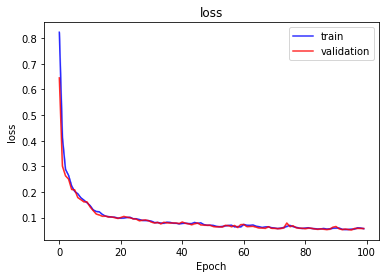

<b>bioma_mse</b>: 0.0000 (min: 0.0000, max: 0.0000)

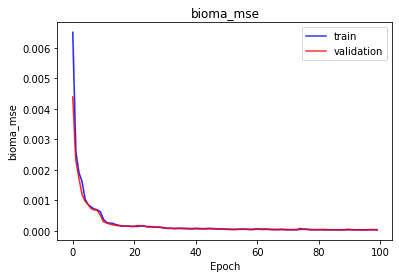

<b>bioma_mae</b>: 0.0019 (min: 0.0019, max: 0.0019)

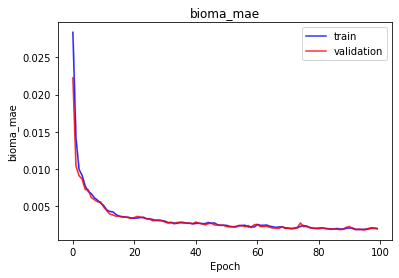

<b>bioma_mape</b>: 2341.9851 (min: 2341.9851, max: 2341.9851)

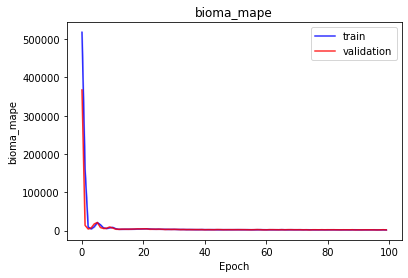

<b>bioma_BrayCurtis</b>: 0.0553 (min: 0.0553, max: 0.0553)

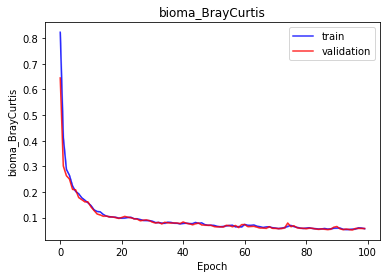

<b>bioma_pearson_corr</b>: 0.9973 (min: 0.9973, max: 0.9973)

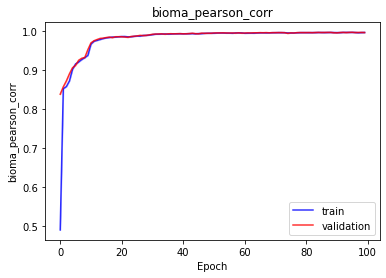

<b>bioma_jensen_shannon_divergence</b>: 0.0686 (min: 0.0686, max: 0.0686)

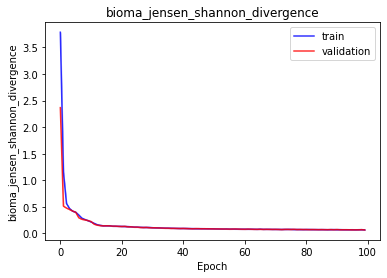

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.05525675616585291 | 0.05525675616585291 | 0.05525675616585291 |
| bioma_mse | 3.347107121953741e-05 | 3.347107121953741e-05 | 3.347107121953741e-05 |
| bioma_mae | 0.0019054606091231108 | 0.0019054606091231108 | 0.0019054606091231108 |
| bioma_mape | 2341.985107421875 | 2341.985107421875 | 2341.985107421875 |
| bioma_BrayCurtis | 0.05525675415992737 | 0.05525675415992737 | 0.05525675415992737 |
| bioma_pearson_corr | 0.9972873330116272 | 0.9972873330116272 | 0.9972873330116272 |
| bioma_jensen_shannon_divergence | 0.0686449408531189 | 0.0686449408531189 | 0.0686449408531189 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.28197363018989563 | 0.28197363018989563 | 0.28197363018989563 |
| pearson_corr | 0.8590456247329712 | 0.8590456247329712 | 0.8590456247329712 |
| jensen_shannon_divergence | 0.42132672667503357 | 0.42132672667503357 | 0.42132672667503357 |


In [10]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=96,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=None,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='sigmoid')(in_layer)
    net = layers.Dense(64, activation='sigmoid')(net)
    net = layers.Dense(32, activation='sigmoid')(net)
    net = layers.Dense(16, activation='sigmoid')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

In [11]:
encoder_biome = encoder
encoder_domain = model_latent
#Guardamos las predicciones
df_microbioma_test.T.to_csv('Results/comida/familia/otus_original_test_OTUcomidaFiltrada_familia.tsv', index=True, header=True, sep='\t')

#run prediction test set from microbiome, i.e, reconstructed
# Input only domain (i.e. environmental features)
pred_latent_biome = encoder_biome.predict(data_microbioma_test)
pred_biome = decoder.predict(pred_latent_biome)

_, _ = save_predicted_otu_table_and_latent(pred_biome,pred_latent_biome,df_microbioma_test.index,df_microbioma_test.columns,'reconstAEfromBiome_OTUcomidaFiltrada_familia')

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_domain_test)
pred_domain = decoder.predict(pred_latent)
df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,df_microbioma_test.index,df_microbioma_test.columns,'predFromDomain_OTUcomidaFiltrada_familia')

#--------------------
actual_array = transform_to_rel_abundance(data_microbioma_test)
RSE_perOTU, RRSE_perOTU  = compute_relative_squared_error(actual_array,pred_domain)

df_error_perOTU = save_errors_per_OTU(RSE_perOTU,RRSE_perOTU,df_microbioma_test.columns,'Results/comida/familia/errors_perOTU_OTUcomidaFiltrada_familia')

In [12]:
metrics = FI()
tabla_FI = pd.DataFrame.from_dict(metrics)
tabla_FI.to_csv("Results/comida/FI/FI_OTU_familia_comidaFiltrada.csv",index=False)

### Order

In [13]:
#Cargamos los datos
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ['F_TOTAL', 'V_TOTAL', 'V_REDOR_TOTAL', 'V_STARCHY_TOTAL', 'V_LEGUMES', 'G_TOTAL', 'PF_TOTAL', 'PF_MEAT', 'PF_CUREDMEAT', 'PF_ORGAN', 'PF_POULT',\
					'PF_SEAFD_HI', 'PF_SEAFD_LOW', 'PF_EGGS', 'PF_SOY', 'PF_NUTSDS', 'D_TOTAL', 'D_YOGURT', 'OILS', 'SOLID_FATS', 'ADD_SUGARS', 'A_DRINKS']
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/nuevos_datos/arreglados/otu_table_Order.csv',metadata_filename='datos-remoto/comidas/metadatos_comidas.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder |   |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 96 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>83</b></p>

<b>loss</b>: 0.0290 (min: 0.0290, max: 0.0290)

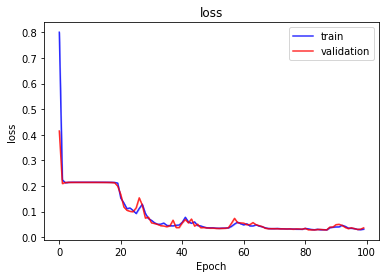

<b>bioma_mse</b>: 0.0000 (min: 0.0000, max: 0.0000)

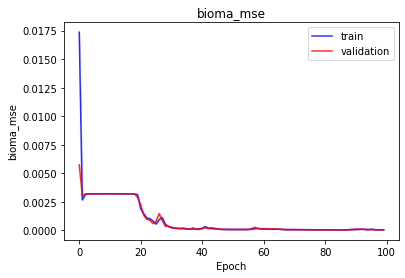

<b>bioma_mae</b>: 0.0018 (min: 0.0018, max: 0.0018)

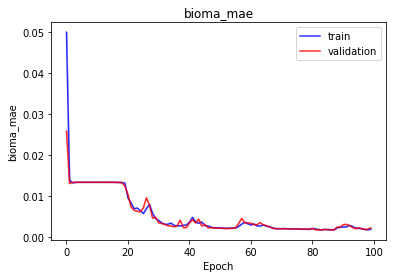

<b>bioma_mape</b>: 2949.9746 (min: 2949.9746, max: 2949.9746)

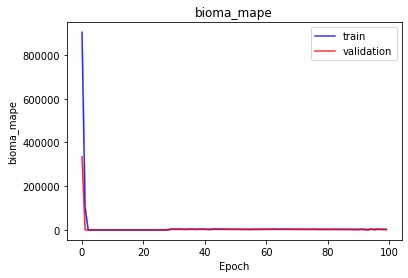

<b>bioma_BrayCurtis</b>: 0.0290 (min: 0.0290, max: 0.0290)

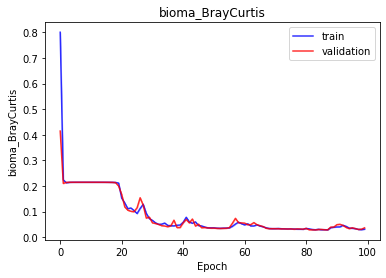

<b>bioma_pearson_corr</b>: 0.9986 (min: 0.9986, max: 0.9986)

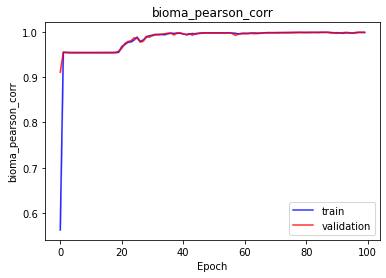

<b>bioma_jensen_shannon_divergence</b>: 0.0425 (min: 0.0425, max: 0.0425)

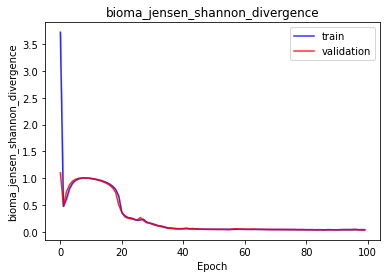

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.02895660937214509 | 0.02895660937214509 | 0.02895660937214509 |
| bioma_mse | 4.070395152666606e-05 | 4.070395152666606e-05 | 4.070395152666606e-05 |
| bioma_mae | 0.0018098169239237905 | 0.0018098169239237905 | 0.0018098169239237905 |
| bioma_mape | 2949.974609375 | 2949.974609375 | 2949.974609375 |
| bioma_BrayCurtis | 0.028956608846783638 | 0.028956608846783638 | 0.028956608846783638 |
| bioma_pearson_corr | 0.9986092448234558 | 0.9986092448234558 | 0.9986092448234558 |
| bioma_jensen_shannon_divergence | 0.0425051748752594 | 0.0425051748752594 | 0.0425051748752594 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.11787591874599457 | 0.11787591874599457 | 0.11787591874599457 |
| pearson_corr | 0.9782185554504395 | 0.9782185554504395 | 0.9782185554504395 |
| jensen_shannon_divergence | 0.11417281627655029 | 0.11417281627655029 | 0.11417281627655029 |


In [14]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=96,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=None,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='sigmoid')(in_layer)
    net = layers.Dense(64, activation='sigmoid')(net)
    net = layers.Dense(32, activation='sigmoid')(net)
    net = layers.Dense(16, activation='sigmoid')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

In [15]:
encoder_biome = encoder
encoder_domain = model_latent
#Guardamos las predicciones
df_microbioma_test.T.to_csv('Results/comida/orden/otus_original_test_OTUcomidaFiltrada_orden.tsv', index=True, header=True, sep='\t')

#run prediction test set from microbiome, i.e, reconstructed
# Input only domain (i.e. environmental features)
pred_latent_biome = encoder_biome.predict(data_microbioma_test)
pred_biome = decoder.predict(pred_latent_biome)

_, _ = save_predicted_otu_table_and_latent(pred_biome,pred_latent_biome,df_microbioma_test.index,df_microbioma_test.columns,'reconstAEfromBiome_OTUcomidaFiltrada_orden')

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_domain_test)
pred_domain = decoder.predict(pred_latent)
df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,df_microbioma_test.index,df_microbioma_test.columns,'predFromDomain_OTUcomidaFiltrada_orden')

#--------------------
actual_array = transform_to_rel_abundance(data_microbioma_test)
RSE_perOTU, RRSE_perOTU  = compute_relative_squared_error(actual_array,pred_domain)

df_error_perOTU = save_errors_per_OTU(RSE_perOTU,RRSE_perOTU,df_microbioma_test.columns,'Results/comida/orden/errors_perOTU_OTUcomidaFiltrada_orden')

In [16]:
metrics = FI()
tabla_FI = pd.DataFrame.from_dict(metrics)
tabla_FI.to_csv("Results/comida/FI/FI_OTU_orden_comidaFiltrada.csv",index=False)

### Class

In [17]:
#Cargamos los datos
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ['F_TOTAL', 'V_TOTAL', 'V_REDOR_TOTAL', 'V_STARCHY_TOTAL', 'V_LEGUMES', 'G_TOTAL', 'PF_TOTAL', 'PF_MEAT', 'PF_CUREDMEAT', 'PF_ORGAN', 'PF_POULT',\
					'PF_SEAFD_HI', 'PF_SEAFD_LOW', 'PF_EGGS', 'PF_SOY', 'PF_NUTSDS', 'D_TOTAL', 'D_YOGURT', 'OILS', 'SOLID_FATS', 'ADD_SUGARS', 'A_DRINKS']
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/nuevos_datos/arreglados/otu_table_Class.csv',metadata_filename='datos-remoto/comidas/metadatos_comidas.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder |   |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 96 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>89</b></p>

<b>loss</b>: 0.0235 (min: 0.0235, max: 0.0235)

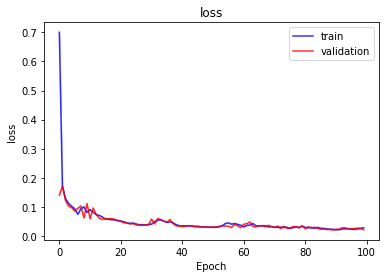

<b>bioma_mse</b>: 0.0000 (min: 0.0000, max: 0.0000)

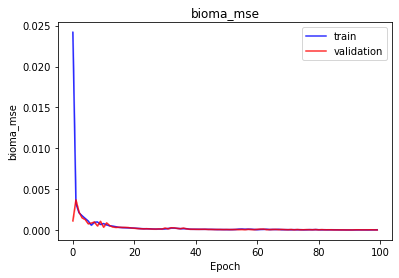

<b>bioma_mae</b>: 0.0025 (min: 0.0025, max: 0.0025)

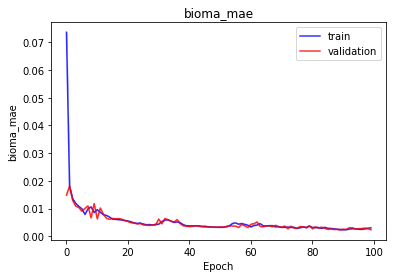

<b>bioma_mape</b>: 3417.0542 (min: 3417.0542, max: 3417.0542)

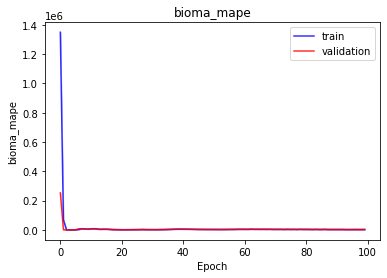

<b>bioma_BrayCurtis</b>: 0.0235 (min: 0.0235, max: 0.0235)

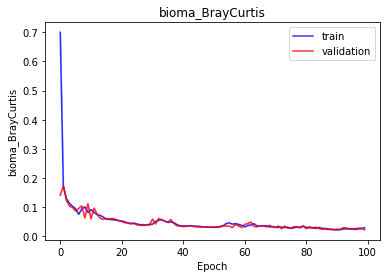

<b>bioma_pearson_corr</b>: 0.9992 (min: 0.9992, max: 0.9992)

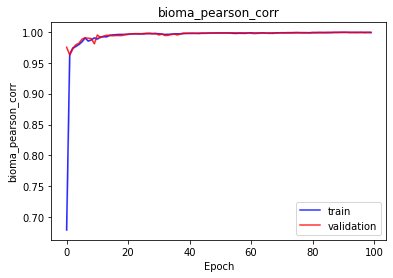

<b>bioma_jensen_shannon_divergence</b>: 0.0303 (min: 0.0303, max: 0.0303)

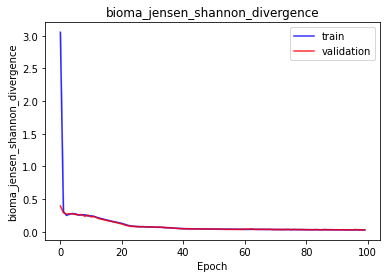

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.023517990437073585 | 0.023517990437073585 | 0.023517990437073585 |
| bioma_mse | 3.8654383388347924e-05 | 3.8654383388347924e-05 | 3.8654383388347924e-05 |
| bioma_mae | 0.002475601388141513 | 0.002475601388141513 | 0.002475601388141513 |
| bioma_mape | 3417.05419921875 | 3417.05419921875 | 3417.05419921875 |
| bioma_BrayCurtis | 0.023517992347478867 | 0.023517992347478867 | 0.023517992347478867 |
| bioma_pearson_corr | 0.9992411136627197 | 0.9992411136627197 | 0.9992411136627197 |
| bioma_jensen_shannon_divergence | 0.030342651531100273 | 0.030342651531100273 | 0.030342651531100273 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.12148883193731308 | 0.12148883193731308 | 0.12148883193731308 |
| pearson_corr | 0.9751318097114563 | 0.9751318097114563 | 0.9751318097114563 |
| jensen_shannon_divergence | 0.11276455968618393 | 0.11276455968618393 | 0.11276455968618393 |


In [18]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=96,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=None,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='sigmoid')(in_layer)
    net = layers.Dense(64, activation='sigmoid')(net)
    net = layers.Dense(32, activation='sigmoid')(net)
    net = layers.Dense(16, activation='sigmoid')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

In [19]:
encoder_biome = encoder
encoder_domain = model_latent
#Guardamos las predicciones
df_microbioma_test.T.to_csv('Results/comida/clase/otus_original_test_OTUcomidaFiltrada_clase.tsv', index=True, header=True, sep='\t')

#run prediction test set from microbiome, i.e, reconstructed
# Input only domain (i.e. environmental features)
pred_latent_biome = encoder_biome.predict(data_microbioma_test)
pred_biome = decoder.predict(pred_latent_biome)

_, _ = save_predicted_otu_table_and_latent(pred_biome,pred_latent_biome,df_microbioma_test.index,df_microbioma_test.columns,'reconstAEfromBiome_OTUcomidaFiltrada_clase')

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_domain_test)
pred_domain = decoder.predict(pred_latent)
df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,df_microbioma_test.index,df_microbioma_test.columns,'predFromDomain_OTUcomidaFiltrada_clase')

#--------------------
actual_array = transform_to_rel_abundance(data_microbioma_test)
RSE_perOTU, RRSE_perOTU  = compute_relative_squared_error(actual_array,pred_domain)

df_error_perOTU = save_errors_per_OTU(RSE_perOTU,RRSE_perOTU,df_microbioma_test.columns,'Results/comida/clase/errors_perOTU_OTUcomidaFiltrada_clase')

In [20]:
metrics = FI()
tabla_FI = pd.DataFrame.from_dict(metrics)
tabla_FI.to_csv("Results/comida/FI/FI_OTU_clase_comidaFiltrada.csv",index=False)

### Phylum

In [21]:
#Cargamos los datos
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ['F_TOTAL', 'V_TOTAL', 'V_REDOR_TOTAL', 'V_STARCHY_TOTAL', 'V_LEGUMES', 'G_TOTAL', 'PF_TOTAL', 'PF_MEAT', 'PF_CUREDMEAT', 'PF_ORGAN', 'PF_POULT',\
					'PF_SEAFD_HI', 'PF_SEAFD_LOW', 'PF_EGGS', 'PF_SOY', 'PF_NUTSDS', 'D_TOTAL', 'D_YOGURT', 'OILS', 'SOLID_FATS', 'ADD_SUGARS', 'A_DRINKS']
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/nuevos_datos/arreglados/otu_table_Phylum.csv',metadata_filename='datos-remoto/comidas/metadatos_comidas.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder |   |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 96 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>78</b></p>

<b>loss</b>: 0.0195 (min: 0.0195, max: 0.0195)

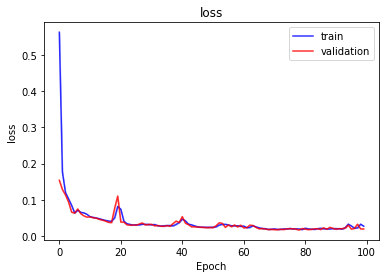

<b>bioma_mse</b>: 0.0001 (min: 0.0001, max: 0.0001)

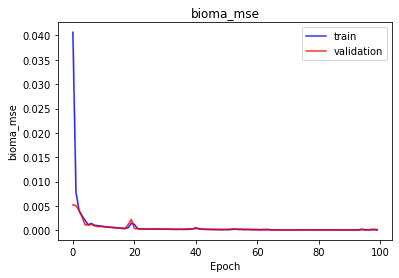

<b>bioma_mae</b>: 0.0043 (min: 0.0043, max: 0.0043)

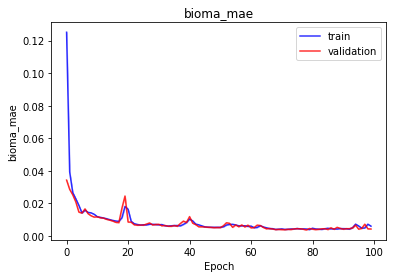

<b>bioma_mape</b>: 3044.3223 (min: 3044.3223, max: 3044.3223)

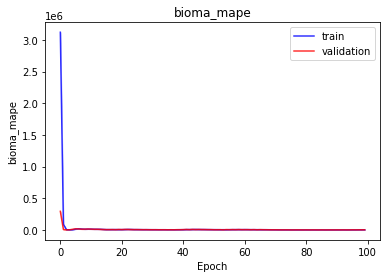

<b>bioma_BrayCurtis</b>: 0.0195 (min: 0.0195, max: 0.0195)

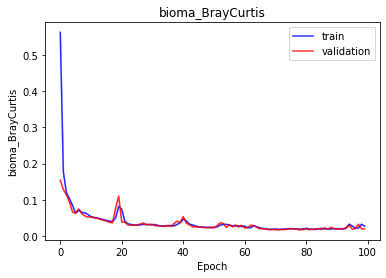

<b>bioma_pearson_corr</b>: 0.9990 (min: 0.9990, max: 0.9990)

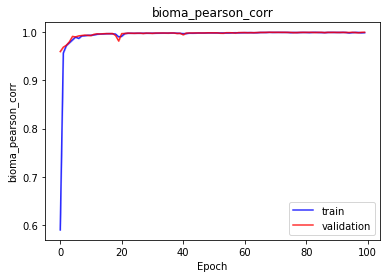

<b>bioma_jensen_shannon_divergence</b>: 0.0166 (min: 0.0166, max: 0.0166)

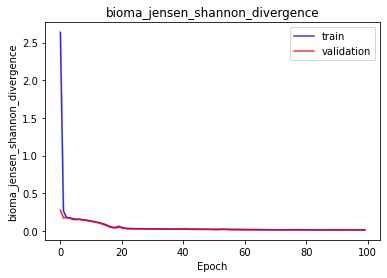

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.019480628558458425 | 0.019480628558458425 | 0.019480628558458425 |
| bioma_mse | 9.564692300045863e-05 | 9.564692300045863e-05 | 9.564692300045863e-05 |
| bioma_mae | 0.004329048562794924 | 0.004329048562794924 | 0.004329048562794924 |
| bioma_mape | 3044.322265625 | 3044.322265625 | 3044.322265625 |
| bioma_BrayCurtis | 0.0194806270301342 | 0.0194806270301342 | 0.0194806270301342 |
| bioma_pearson_corr | 0.9989804029464722 | 0.9989804029464722 | 0.9989804029464722 |
| bioma_jensen_shannon_divergence | 0.016613487154245377 | 0.016613487154245377 | 0.016613487154245377 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.12149401009082794 | 0.12149401009082794 | 0.12149401009082794 |
| pearson_corr | 0.9716500043869019 | 0.9716500043869019 | 0.9716500043869019 |
| jensen_shannon_divergence | 0.0965336263179779 | 0.0965336263179779 | 0.0965336263179779 |


In [22]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=96,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=None,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='sigmoid')(in_layer)
    net = layers.Dense(64, activation='sigmoid')(net)
    net = layers.Dense(32, activation='sigmoid')(net)
    net = layers.Dense(16, activation='sigmoid')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

In [23]:
encoder_biome = encoder
encoder_domain = model_latent
#Guardamos las predicciones
df_microbioma_test.T.to_csv('Results/comida/filo/otus_original_test_OTUcomidaFiltrada_filo.tsv', index=True, header=True, sep='\t')

#run prediction test set from microbiome, i.e, reconstructed
# Input only domain (i.e. environmental features)
pred_latent_biome = encoder_biome.predict(data_microbioma_test)
pred_biome = decoder.predict(pred_latent_biome)

_, _ = save_predicted_otu_table_and_latent(pred_biome,pred_latent_biome,df_microbioma_test.index,df_microbioma_test.columns,'reconstAEfromBiome_OTUcomidaFiltrada_filo')

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_domain_test)
pred_domain = decoder.predict(pred_latent)
df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,df_microbioma_test.index,df_microbioma_test.columns,'predFromDomain_OTUcomidaFiltrada_filo')

#--------------------
actual_array = transform_to_rel_abundance(data_microbioma_test)
RSE_perOTU, RRSE_perOTU  = compute_relative_squared_error(actual_array,pred_domain)

df_error_perOTU = save_errors_per_OTU(RSE_perOTU,RRSE_perOTU,df_microbioma_test.columns,'Results/comida/filo/errors_perOTU_OTUcomidaFiltrada_filo')

In [24]:
metrics = FI()
tabla_FI = pd.DataFrame.from_dict(metrics)
tabla_FI.to_csv("Results/comida/FI/FI_OTU_filo_comidaFiltrada.csv",index=False)

--------------------------
--------------------------
# Latent Combined

### Genus

In [25]:
#Cargamos los datos
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ['F_TOTAL', 'V_TOTAL', 'V_REDOR_TOTAL', 'V_STARCHY_TOTAL', 'V_LEGUMES', 'G_TOTAL', 'PF_TOTAL', 'PF_MEAT', 'PF_CUREDMEAT', 'PF_ORGAN', 'PF_POULT',\
					'PF_SEAFD_HI', 'PF_SEAFD_LOW', 'PF_EGGS', 'PF_SOY', 'PF_NUTSDS', 'D_TOTAL', 'D_YOGURT', 'OILS', 'SOLID_FATS', 'ADD_SUGARS', 'A_DRINKS']
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/nuevos_datos/arreglados/otu_table_Genus.csv',metadata_filename='datos-remoto/comidas/metadatos_comidas.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 15 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>98</b></p>

<b>loss</b>: 0.3714 (min: 0.3714, max: 0.3714)

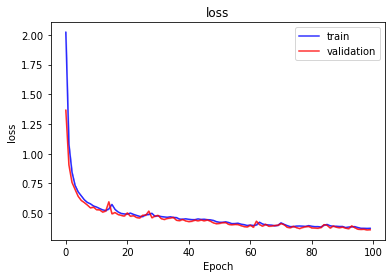

<b>bioma_loss</b>: 0.0988 (min: 0.0988, max: 0.0988)

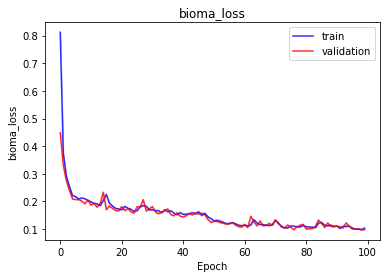

<b>domain_loss</b>: 0.2433 (min: 0.2433, max: 0.2433)

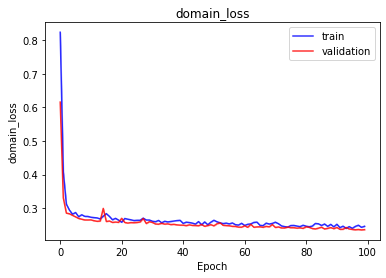

<b>latent_loss</b>: 0.0273 (min: 0.0273, max: 0.0273)

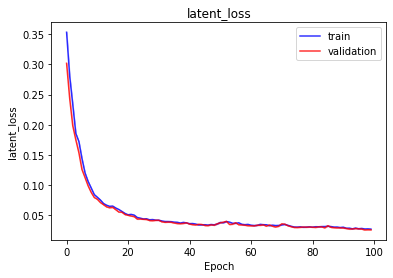

<b>bioma_mse</b>: 0.0000 (min: 0.0000, max: 0.0000)

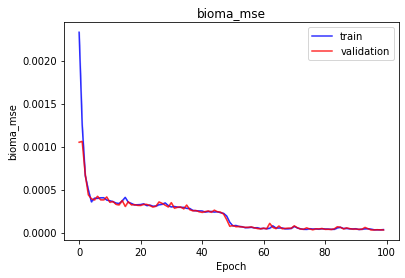

<b>bioma_mae</b>: 0.0012 (min: 0.0012, max: 0.0012)

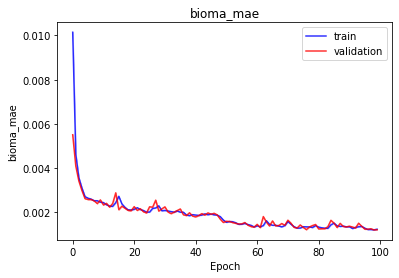

<b>bioma_mape</b>: 1855.8015 (min: 1855.8015, max: 1855.8015)

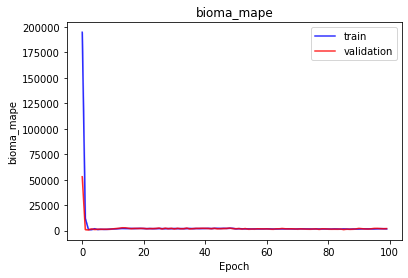

<b>bioma_BrayCurtis</b>: 0.0994 (min: 0.0994, max: 0.0994)

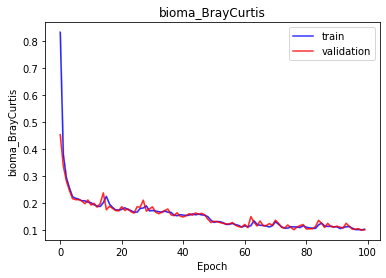

<b>bioma_pearson_corr</b>: 0.9922 (min: 0.9922, max: 0.9922)

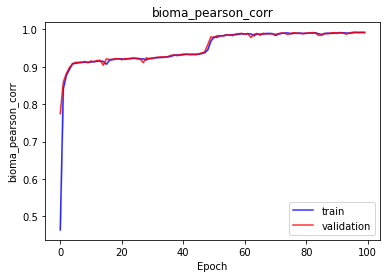

<b>bioma_jensen_shannon_divergence</b>: 0.1755 (min: 0.1755, max: 0.1755)

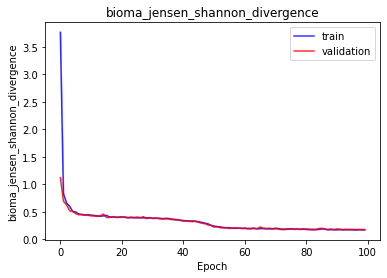

<b>domain_mse</b>: 0.0006 (min: 0.0006, max: 0.0006)

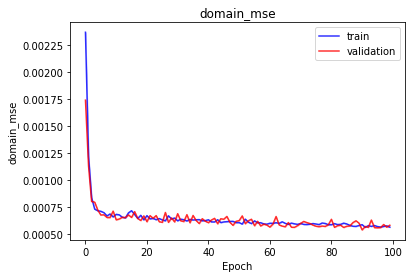

<b>domain_mae</b>: 0.0030 (min: 0.0030, max: 0.0030)

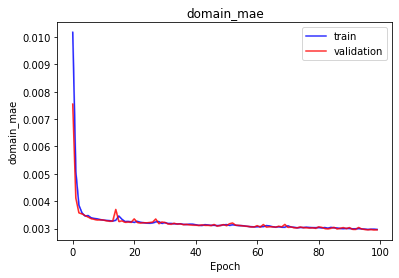

<b>domain_mape</b>: 1623.8575 (min: 1623.8575, max: 1623.8575)

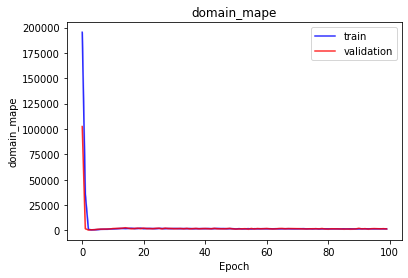

<b>domain_BrayCurtis</b>: 0.2447 (min: 0.2447, max: 0.2447)

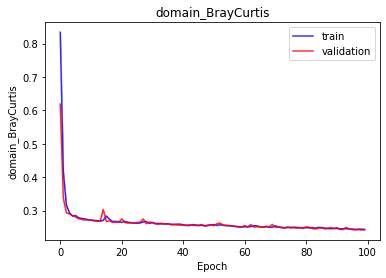

<b>domain_pearson_corr</b>: 0.8887 (min: 0.8887, max: 0.8887)

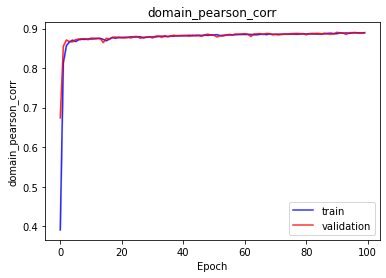

<b>domain_jensen_shannon_divergence</b>: 0.4830 (min: 0.4830, max: 0.4830)

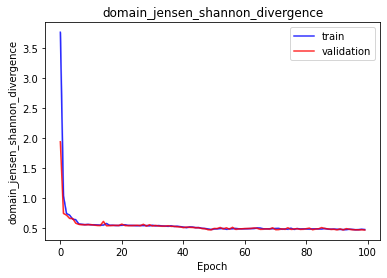

<b>latent_mae</b>: 0.0273 (min: 0.0273, max: 0.0273)

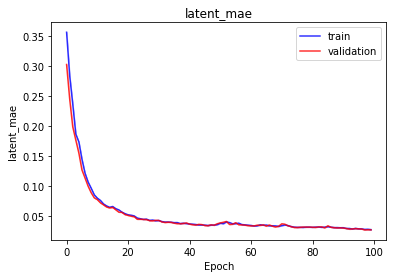

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.371407748797001 | 0.371407748797001 | 0.371407748797001 |
| bioma_loss | 0.09878586232662201 | 0.09878586232662201 | 0.09878586232662201 |
| domain_loss | 0.2433159202337265 | 0.2433159202337265 | 0.2433159202337265 |
| latent_loss | 0.027349837124347687 | 0.027349837124347687 | 0.027349837124347687 |
| bioma_mse | 3.2866915717022493e-05 | 3.2866915717022493e-05 | 3.2866915717022493e-05 |
| bioma_mae | 0.001212430652230978 | 0.001212430652230978 | 0.001212430652230978 |
| bioma_mape | 1855.801513671875 | 1855.801513671875 | 1855.801513671875 |
| bioma_BrayCurtis | 0.09941117465496063 | 0.09941117465496063 | 0.09941117465496063 |
| bioma_pearson_corr | 0.9922130703926086 | 0.9922130703926086 | 0.9922130703926086 |
| bioma_jensen_shannon_divergence | 0.17547687888145447 | 0.17547687888145447 | 0.17547687888145447 |
| domain_mse | 0.0005733323632739484 | 0.0005733323632739484 | 0.0005733323632739484 |
| domain_mae | 0.0029841712675988674 | 0.0029841712675988674 | 0.0029841712675988674 |
| domain_mape | 1623.8575439453125 | 1623.8575439453125 | 1623.8575439453125 |
| domain_BrayCurtis | 0.24468201398849487 | 0.24468201398849487 | 0.24468201398849487 |
| domain_pearson_corr | 0.8887341618537903 | 0.8887341618537903 | 0.8887341618537903 |
| domain_jensen_shannon_divergence | 0.4830368459224701 | 0.4830368459224701 | 0.4830368459224701 |
| latent_mae | 0.027314579114317894 | 0.027314579114317894 | 0.027314579114317894 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.27880704402923584 | 0.27880704402923584 | 0.27880704402923584 |
| pearson_corr | 0.8743826746940613 | 0.8743826746940613 | 0.8743826746940613 |
| jensen_shannon_divergence | 0.4885520040988922 | 0.4885520040988922 | 0.4885520040988922 |


In [26]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='relu')(in_layer)
    net = layers.Dense(64, activation='relu')(net)
    net = layers.Dense(32, activation='relu')(net)
    net = layers.Dense(16, activation='relu')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

In [27]:
encoder_biome = encoder
encoder_domain = model_latent
#Guardamos las predicciones
df_microbioma_test.T.to_csv('Results/comida/genero/otus_original_test_CombinedcomidaFiltrada_genero.tsv', index=True, header=True, sep='\t')

#run prediction test set from microbiome, i.e, reconstructed
# Input only domain (i.e. environmental features)
pred_latent_biome = encoder_biome.predict(data_microbioma_test)
pred_biome = decoder.predict(pred_latent_biome)

_, _ = save_predicted_otu_table_and_latent(pred_biome,pred_latent_biome,df_microbioma_test.index,df_microbioma_test.columns,'reconstAEfromBiome_CombinedcomidaFiltrada_genero')

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_domain_test)
pred_domain = decoder.predict(pred_latent)
df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,df_microbioma_test.index,df_microbioma_test.columns,'predFromDomain_CombinedcomidaFiltrada_genero')

#--------------------
actual_array = transform_to_rel_abundance(data_microbioma_test)
RSE_perOTU, RRSE_perOTU  = compute_relative_squared_error(actual_array,pred_domain)

df_error_perOTU = save_errors_per_OTU(RSE_perOTU,RRSE_perOTU,df_microbioma_test.columns,'Results/comida/genero/errors_perOTU_CombinedcomidaFiltrada_genero')

In [28]:
metrics = FI()
tabla_FI = pd.DataFrame.from_dict(metrics)
tabla_FI.to_csv("Results/comida/FI/FI_Combined_genus_comidaFiltrada.csv",index=False)

### Family

In [29]:
#Cargamos los datos
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ['F_TOTAL', 'V_TOTAL', 'V_REDOR_TOTAL', 'V_STARCHY_TOTAL', 'V_LEGUMES', 'G_TOTAL', 'PF_TOTAL', 'PF_MEAT', 'PF_CUREDMEAT', 'PF_ORGAN', 'PF_POULT',\
					'PF_SEAFD_HI', 'PF_SEAFD_LOW', 'PF_EGGS', 'PF_SOY', 'PF_NUTSDS', 'D_TOTAL', 'D_YOGURT', 'OILS', 'SOLID_FATS', 'ADD_SUGARS', 'A_DRINKS']
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/nuevos_datos/arreglados/otu_table_Family.csv',metadata_filename='datos-remoto/comidas/metadatos_comidas.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 15 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>99</b></p>

<b>loss</b>: 0.3392 (min: 0.3392, max: 0.3392)

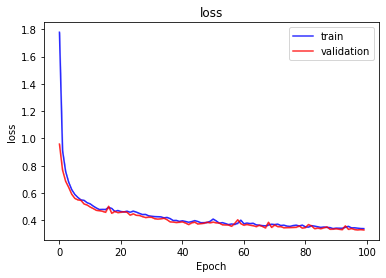

<b>bioma_loss</b>: 0.0847 (min: 0.0847, max: 0.0847)

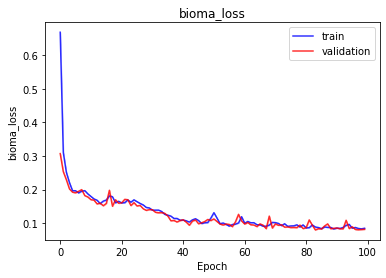

<b>domain_loss</b>: 0.2309 (min: 0.2309, max: 0.2309)

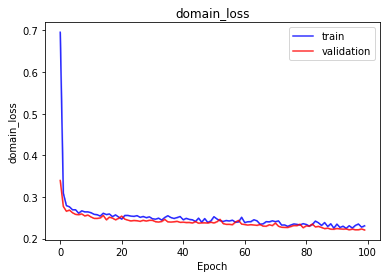

<b>latent_loss</b>: 0.0277 (min: 0.0277, max: 0.0277)

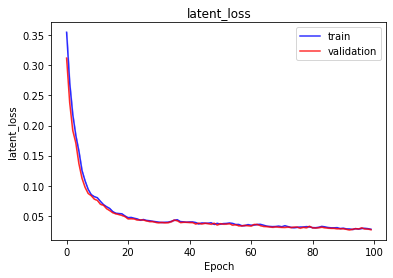

<b>bioma_mse</b>: 0.0001 (min: 0.0001, max: 0.0001)

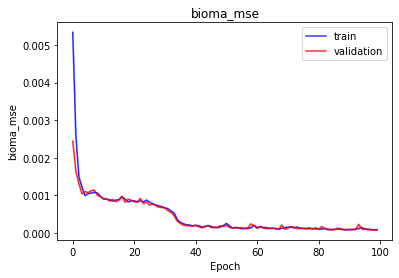

<b>bioma_mae</b>: 0.0029 (min: 0.0029, max: 0.0029)

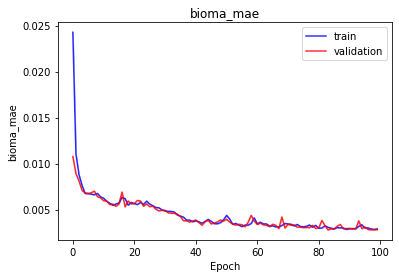

<b>bioma_mape</b>: 2444.9592 (min: 2444.9592, max: 2444.9592)

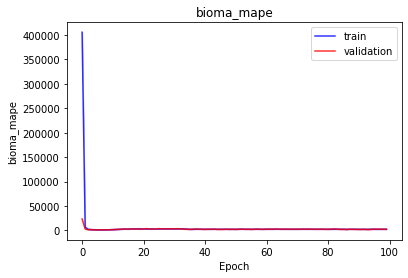

<b>bioma_BrayCurtis</b>: 0.0842 (min: 0.0842, max: 0.0842)

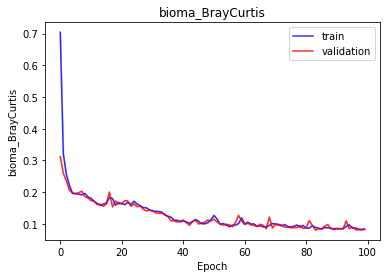

<b>bioma_pearson_corr</b>: 0.9923 (min: 0.9923, max: 0.9923)

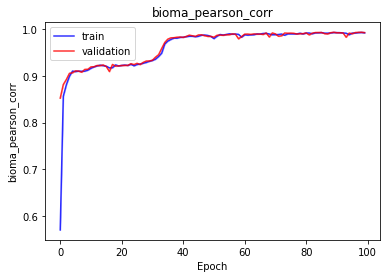

<b>bioma_jensen_shannon_divergence</b>: 0.1010 (min: 0.1010, max: 0.1010)

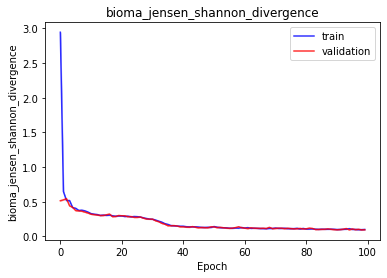

<b>domain_mse</b>: 0.0015 (min: 0.0015, max: 0.0015)

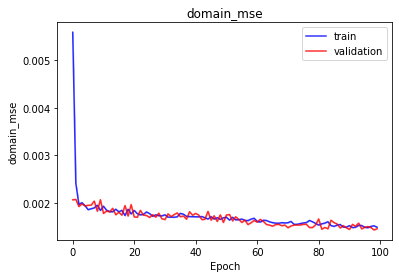

<b>domain_mae</b>: 0.0079 (min: 0.0079, max: 0.0079)

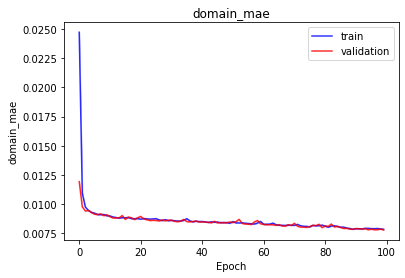

<b>domain_mape</b>: 2108.8538 (min: 2108.8538, max: 2108.8538)

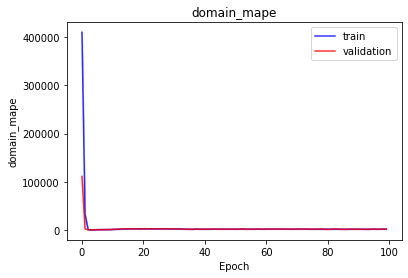

<b>domain_BrayCurtis</b>: 0.2277 (min: 0.2277, max: 0.2277)

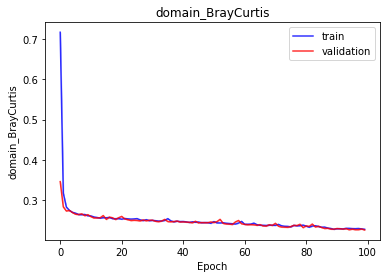

<b>domain_pearson_corr</b>: 0.8902 (min: 0.8902, max: 0.8902)

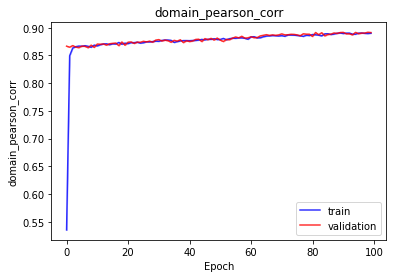

<b>domain_jensen_shannon_divergence</b>: 0.3694 (min: 0.3694, max: 0.3694)

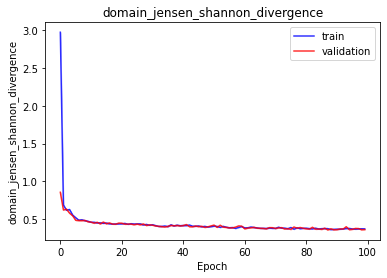

<b>latent_mae</b>: 0.0273 (min: 0.0273, max: 0.0273)

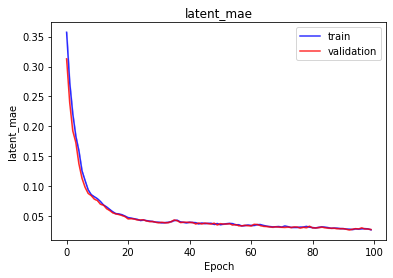

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.3392229897853656 | 0.3392229897853656 | 0.3392229897853656 |
| bioma_loss | 0.0846622884273529 | 0.0846622884273529 | 0.0846622884273529 |
| domain_loss | 0.23086035251617432 | 0.23086035251617432 | 0.23086035251617432 |
| latent_loss | 0.02774813584983349 | 0.02774813584983349 | 0.02774813584983349 |
| bioma_mse | 9.202336514135823e-05 | 9.202336514135823e-05 | 9.202336514135823e-05 |
| bioma_mae | 0.0029033441096544266 | 0.0029033441096544266 | 0.0029033441096544266 |
| bioma_mape | 2444.959228515625 | 2444.959228515625 | 2444.959228515625 |
| bioma_BrayCurtis | 0.08419453352689743 | 0.08419453352689743 | 0.08419453352689743 |
| bioma_pearson_corr | 0.9923335909843445 | 0.9923335909843445 | 0.9923335909843445 |
| bioma_jensen_shannon_divergence | 0.10100381076335907 | 0.10100381076335907 | 0.10100381076335907 |
| domain_mse | 0.0014831230510026217 | 0.0014831230510026217 | 0.0014831230510026217 |
| domain_mae | 0.007851779460906982 | 0.007851779460906982 | 0.007851779460906982 |
| domain_mape | 2108.853759765625 | 2108.853759765625 | 2108.853759765625 |
| domain_BrayCurtis | 0.22769498825073242 | 0.22769498825073242 | 0.22769498825073242 |
| domain_pearson_corr | 0.8901832699775696 | 0.8901832699775696 | 0.8901832699775696 |
| domain_jensen_shannon_divergence | 0.3694224953651428 | 0.3694224953651428 | 0.3694224953651428 |
| latent_mae | 0.02733347751200199 | 0.02733347751200199 | 0.02733347751200199 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.2858896553516388 | 0.2858896553516388 | 0.2858896553516388 |
| pearson_corr | 0.8476073145866394 | 0.8476073145866394 | 0.8476073145866394 |
| jensen_shannon_divergence | 0.4911046624183655 | 0.4911046624183655 | 0.4911046624183655 |


In [30]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='relu')(in_layer)
    net = layers.Dense(64, activation='relu')(net)
    net = layers.Dense(32, activation='relu')(net)
    net = layers.Dense(16, activation='relu')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

In [31]:
encoder_biome = encoder
encoder_domain = model_latent
#Guardamos las predicciones
df_microbioma_test.T.to_csv('Results/comida/familia/otus_original_test_CombinedcomidaFiltrada_familia.tsv', index=True, header=True, sep='\t')

#run prediction test set from microbiome, i.e, reconstructed
# Input only domain (i.e. environmental features)
pred_latent_biome = encoder_biome.predict(data_microbioma_test)
pred_biome = decoder.predict(pred_latent_biome)

_, _ = save_predicted_otu_table_and_latent(pred_biome,pred_latent_biome,df_microbioma_test.index,df_microbioma_test.columns,'reconstAEfromBiome_CombinedcomidaFiltrada_familia')

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_domain_test)
pred_domain = decoder.predict(pred_latent)
df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,df_microbioma_test.index,df_microbioma_test.columns,'predFromDomain_CombinedcomidaFiltrada_familia')

#--------------------
actual_array = transform_to_rel_abundance(data_microbioma_test)
RSE_perOTU, RRSE_perOTU  = compute_relative_squared_error(actual_array,pred_domain)

df_error_perOTU = save_errors_per_OTU(RSE_perOTU,RRSE_perOTU,df_microbioma_test.columns,'Results/comida/familia/errors_perOTU_CombinedcomidaFiltrada_familia')

In [32]:
metrics = FI()
tabla_FI = pd.DataFrame.from_dict(metrics)
tabla_FI.to_csv("Results/comida/FI/FI_Combined_familia_comidaFiltrada.csv",index=False)

### Order

In [33]:
#Cargamos los datos
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ['F_TOTAL', 'V_TOTAL', 'V_REDOR_TOTAL', 'V_STARCHY_TOTAL', 'V_LEGUMES', 'G_TOTAL', 'PF_TOTAL', 'PF_MEAT', 'PF_CUREDMEAT', 'PF_ORGAN', 'PF_POULT',\
					'PF_SEAFD_HI', 'PF_SEAFD_LOW', 'PF_EGGS', 'PF_SOY', 'PF_NUTSDS', 'D_TOTAL', 'D_YOGURT', 'OILS', 'SOLID_FATS', 'ADD_SUGARS', 'A_DRINKS']
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/nuevos_datos/arreglados/otu_table_Order.csv',metadata_filename='datos-remoto/comidas/metadatos_comidas.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 15 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>83</b></p>

<b>loss</b>: 0.4332 (min: 0.4332, max: 0.4332)

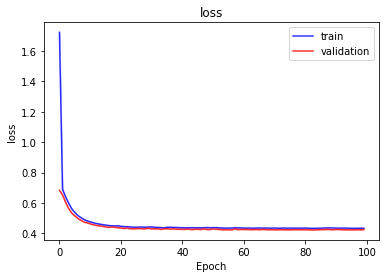

<b>bioma_loss</b>: 0.2150 (min: 0.2150, max: 0.2150)

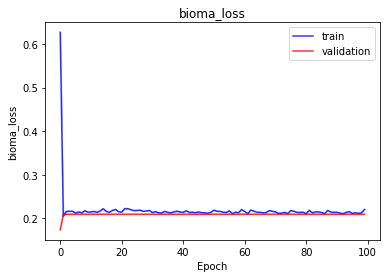

<b>domain_loss</b>: 0.2150 (min: 0.2150, max: 0.2150)

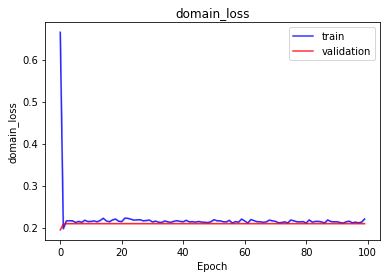

<b>latent_loss</b>: 0.0037 (min: 0.0037, max: 0.0037)

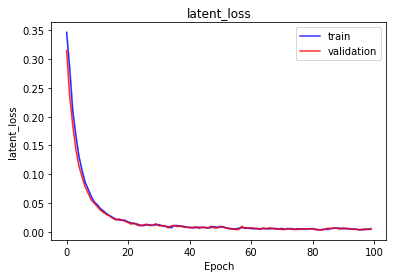

<b>bioma_mse</b>: 0.0032 (min: 0.0032, max: 0.0032)

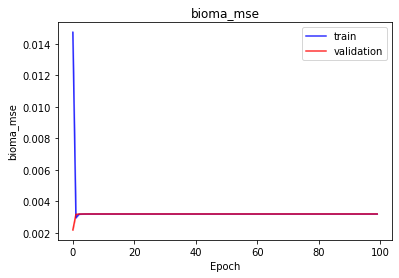

<b>bioma_mae</b>: 0.0134 (min: 0.0134, max: 0.0134)

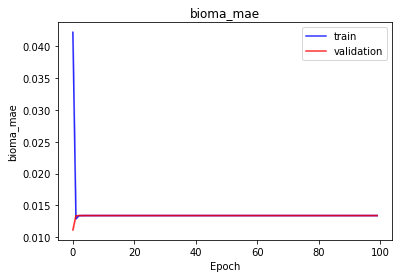

<b>bioma_mape</b>: 98.3953 (min: 98.3953, max: 98.3953)

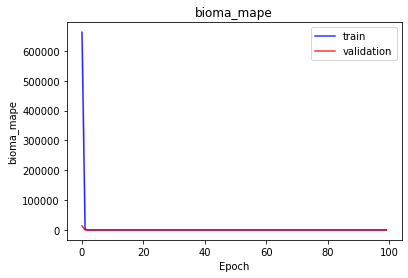

<b>bioma_BrayCurtis</b>: 0.2147 (min: 0.2147, max: 0.2147)

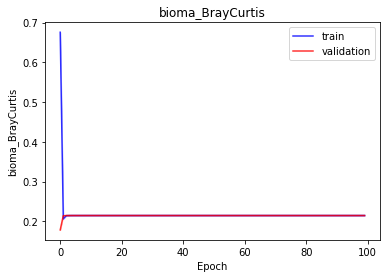

<b>bioma_pearson_corr</b>: 0.9540 (min: 0.9540, max: 0.9540)

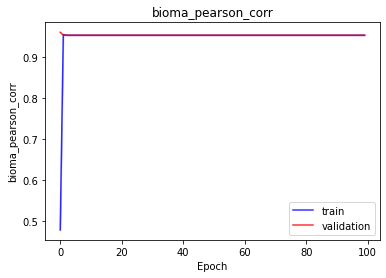

<b>bioma_jensen_shannon_divergence</b>: 1.3388 (min: 1.3388, max: 1.3388)

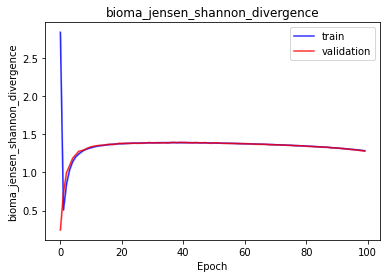

<b>domain_mse</b>: 0.0032 (min: 0.0032, max: 0.0032)

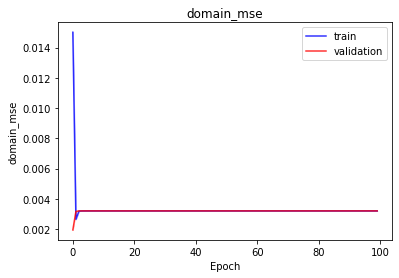

<b>domain_mae</b>: 0.0134 (min: 0.0134, max: 0.0134)

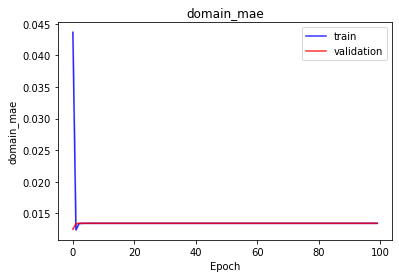

<b>domain_mape</b>: 98.3952 (min: 98.3952, max: 98.3952)

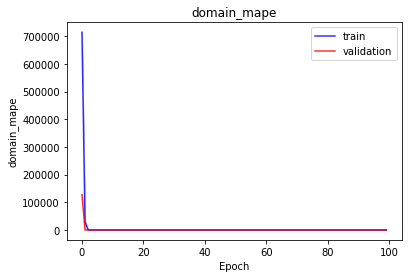

<b>domain_BrayCurtis</b>: 0.2147 (min: 0.2147, max: 0.2147)

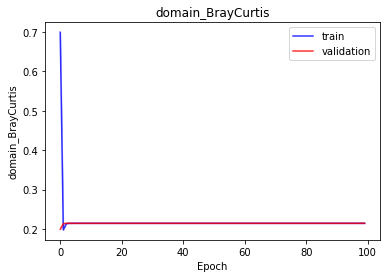

<b>domain_pearson_corr</b>: 0.9540 (min: 0.9540, max: 0.9540)

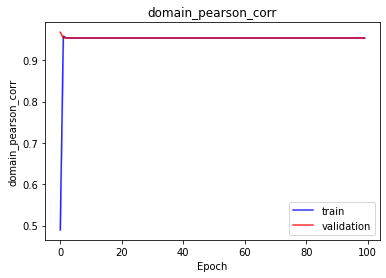

<b>domain_jensen_shannon_divergence</b>: 1.3387 (min: 1.3387, max: 1.3387)

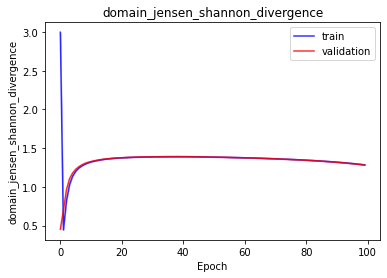

<b>latent_mae</b>: 0.0037 (min: 0.0037, max: 0.0037)

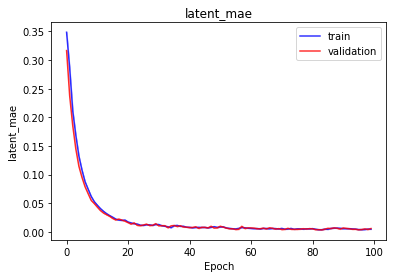

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.4331636675912091 | 0.4331636675912091 | 0.4331636675912091 |
| bioma_loss | 0.214997798204422 | 0.214997798204422 | 0.214997798204422 |
| domain_loss | 0.2149977833032608 | 0.2149977833032608 | 0.2149977833032608 |
| latent_loss | 0.003704480128362775 | 0.003704480128362775 | 0.003704480128362775 |
| bioma_mse | 0.003207581350579858 | 0.003207581350579858 | 0.003207581350579858 |
| bioma_mae | 0.013420882634818554 | 0.013420882634818554 | 0.013420882634818554 |
| bioma_mape | 98.39527893066406 | 98.39527893066406 | 98.39527893066406 |
| bioma_BrayCurtis | 0.21473073959350586 | 0.21473073959350586 | 0.21473073959350586 |
| bioma_pearson_corr | 0.9540337324142456 | 0.9540337324142456 | 0.9540337324142456 |
| bioma_jensen_shannon_divergence | 1.3387757539749146 | 1.3387757539749146 | 1.3387757539749146 |
| domain_mse | 0.003207581117749214 | 0.003207581117749214 | 0.003207581117749214 |
| domain_mae | 0.013420882634818554 | 0.013420882634818554 | 0.013420882634818554 |
| domain_mape | 98.39520263671875 | 98.39520263671875 | 98.39520263671875 |
| domain_BrayCurtis | 0.21473072469234467 | 0.21473072469234467 | 0.21473072469234467 |
| domain_pearson_corr | 0.9540337324142456 | 0.9540337324142456 | 0.9540337324142456 |
| domain_jensen_shannon_divergence | 1.338679313659668 | 1.338679313659668 | 1.338679313659668 |
| latent_mae | 0.003702196991071105 | 0.003702196991071105 | 0.003702196991071105 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.21447865664958954 | 0.21447865664958954 | 0.21447865664958954 |
| pearson_corr | 0.9567607045173645 | 0.9567607045173645 | 0.9567607045173645 |
| jensen_shannon_divergence | 1.265238881111145 | 1.265238881111145 | 1.265238881111145 |


In [34]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='relu')(in_layer)
    net = layers.Dense(64, activation='relu')(net)
    net = layers.Dense(32, activation='relu')(net)
    net = layers.Dense(16, activation='relu')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

In [35]:
encoder_biome = encoder
encoder_domain = model_latent
#Guardamos las predicciones
df_microbioma_test.T.to_csv('Results/comida/orden/otus_original_test_CombinedcomidaFiltrada_orden.tsv', index=True, header=True, sep='\t')

#run prediction test set from microbiome, i.e, reconstructed
# Input only domain (i.e. environmental features)
pred_latent_biome = encoder_biome.predict(data_microbioma_test)
pred_biome = decoder.predict(pred_latent_biome)

_, _ = save_predicted_otu_table_and_latent(pred_biome,pred_latent_biome,df_microbioma_test.index,df_microbioma_test.columns,'reconstAEfromBiome_CombinedcomidaFiltrada_gorden')

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_domain_test)
pred_domain = decoder.predict(pred_latent)
df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,df_microbioma_test.index,df_microbioma_test.columns,'predFromDomain_CombinedcomidaFiltrada_orden')

#--------------------
actual_array = transform_to_rel_abundance(data_microbioma_test)
RSE_perOTU, RRSE_perOTU  = compute_relative_squared_error(actual_array,pred_domain)

df_error_perOTU = save_errors_per_OTU(RSE_perOTU,RRSE_perOTU,df_microbioma_test.columns,'Results/comida/orden/errors_perOTU_CombinedcomidaFiltrada_orden')

In [36]:
metrics = FI()
tabla_FI = pd.DataFrame.from_dict(metrics)
tabla_FI.to_csv("Results/comida/FI/FI_Combined_orden_comidaFiltrada.csv",index=False)

### Class

In [37]:
#Cargamos los datos
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ['F_TOTAL', 'V_TOTAL', 'V_REDOR_TOTAL', 'V_STARCHY_TOTAL', 'V_LEGUMES', 'G_TOTAL', 'PF_TOTAL', 'PF_MEAT', 'PF_CUREDMEAT', 'PF_ORGAN', 'PF_POULT',\
					'PF_SEAFD_HI', 'PF_SEAFD_LOW', 'PF_EGGS', 'PF_SOY', 'PF_NUTSDS', 'D_TOTAL', 'D_YOGURT', 'OILS', 'SOLID_FATS', 'ADD_SUGARS', 'A_DRINKS']
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/nuevos_datos/arreglados/otu_table_Class.csv',metadata_filename='datos-remoto/comidas/metadatos_comidas.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 15 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>86</b></p>

<b>loss</b>: 0.1446 (min: 0.1446, max: 0.1446)

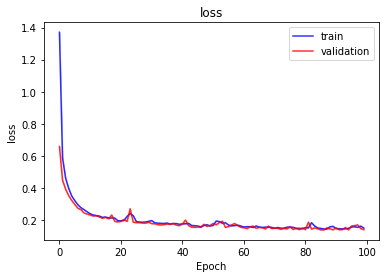

<b>bioma_loss</b>: 0.0402 (min: 0.0402, max: 0.0402)

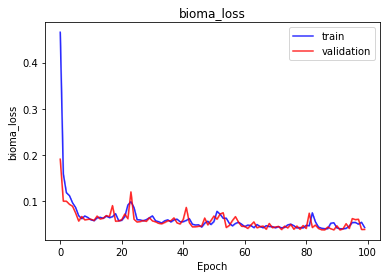

<b>domain_loss</b>: 0.0918 (min: 0.0918, max: 0.0918)

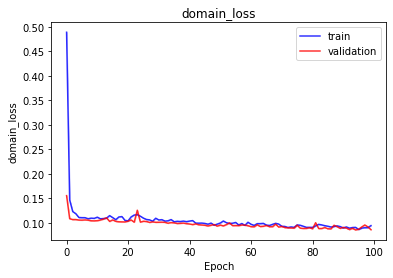

<b>latent_loss</b>: 0.0130 (min: 0.0130, max: 0.0130)

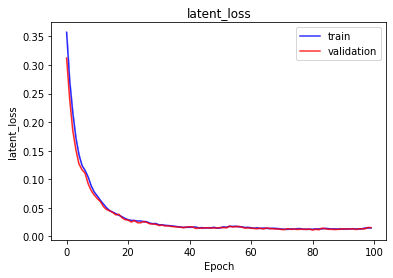

<b>bioma_mse</b>: 0.0001 (min: 0.0001, max: 0.0001)

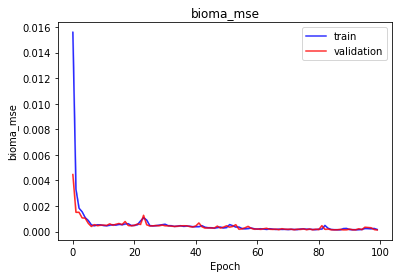

<b>bioma_mae</b>: 0.0042 (min: 0.0042, max: 0.0042)

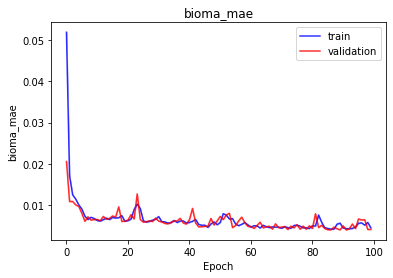

<b>bioma_mape</b>: 3182.9456 (min: 3182.9456, max: 3182.9456)

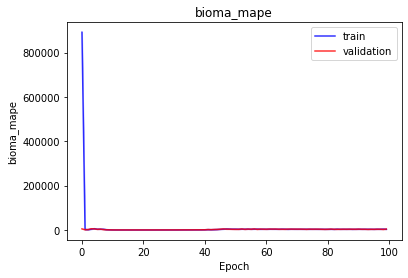

<b>bioma_BrayCurtis</b>: 0.0398 (min: 0.0398, max: 0.0398)

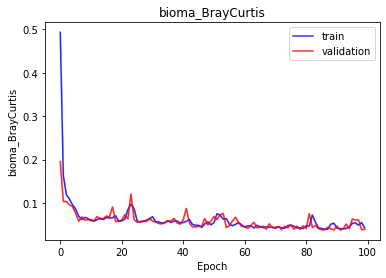

<b>bioma_pearson_corr</b>: 0.9973 (min: 0.9973, max: 0.9973)

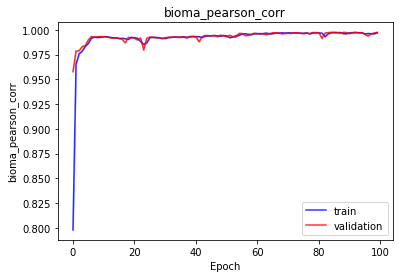

<b>bioma_jensen_shannon_divergence</b>: 0.0457 (min: 0.0457, max: 0.0457)

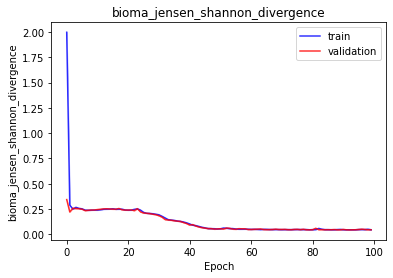

<b>domain_mse</b>: 0.0014 (min: 0.0014, max: 0.0014)

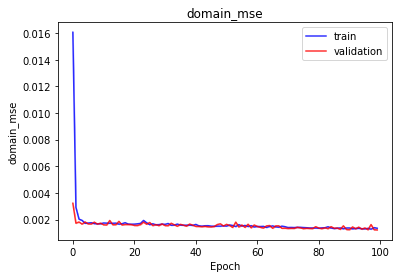

<b>domain_mae</b>: 0.0097 (min: 0.0097, max: 0.0097)

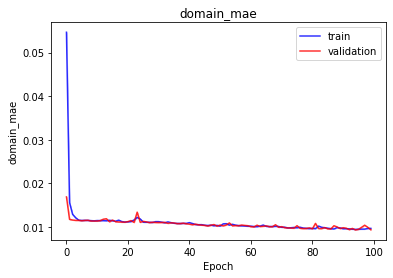

<b>domain_mape</b>: 2420.2271 (min: 2420.2271, max: 2420.2271)

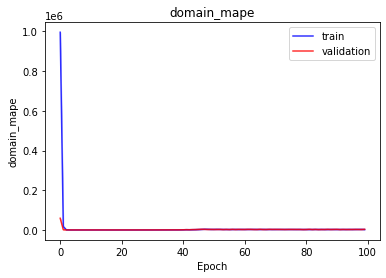

<b>domain_BrayCurtis</b>: 0.0918 (min: 0.0918, max: 0.0918)

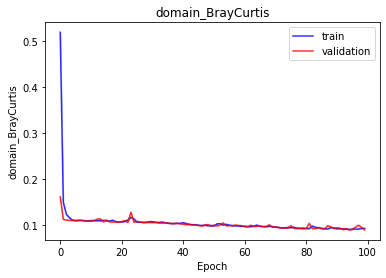

<b>domain_pearson_corr</b>: 0.9797 (min: 0.9797, max: 0.9797)

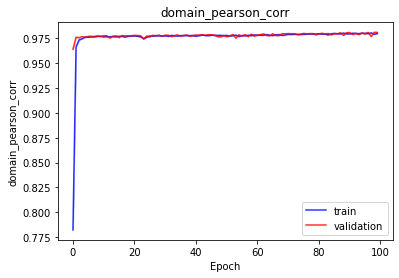

<b>domain_jensen_shannon_divergence</b>: 0.0917 (min: 0.0917, max: 0.0917)

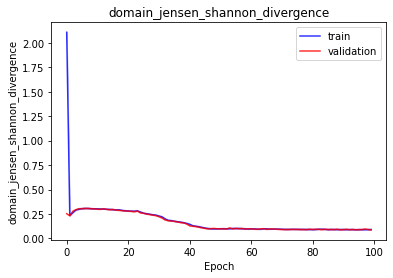

<b>latent_mae</b>: 0.0130 (min: 0.0130, max: 0.0130)

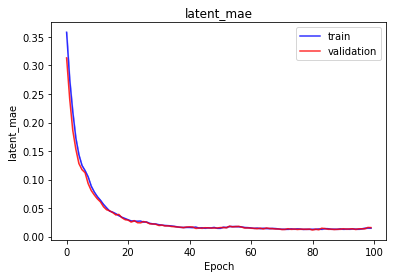

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.14456989291386727 | 0.14456989291386727 | 0.14456989291386727 |
| bioma_loss | 0.04016568139195442 | 0.04016568139195442 | 0.04016568139195442 |
| domain_loss | 0.09179627150297165 | 0.09179627150297165 | 0.09179627150297165 |
| latent_loss | 0.012991304509341717 | 0.012991304509341717 | 0.012991304509341717 |
| bioma_mse | 0.00014922161062713712 | 0.00014922161062713712 | 0.00014922161062713712 |
| bioma_mae | 0.004190488252788782 | 0.004190488252788782 | 0.004190488252788782 |
| bioma_mape | 3182.945556640625 | 3182.945556640625 | 3182.945556640625 |
| bioma_BrayCurtis | 0.03980926424264908 | 0.03980926424264908 | 0.03980926424264908 |
| bioma_pearson_corr | 0.9972552061080933 | 0.9972552061080933 | 0.9972552061080933 |
| bioma_jensen_shannon_divergence | 0.045687880367040634 | 0.045687880367040634 | 0.045687880367040634 |
| domain_mse | 0.0013645727885887027 | 0.0013645727885887027 | 0.0013645727885887027 |
| domain_mae | 0.009658746421337128 | 0.009658746421337128 | 0.009658746421337128 |
| domain_mape | 2420.22705078125 | 2420.22705078125 | 2420.22705078125 |
| domain_BrayCurtis | 0.09175722301006317 | 0.09175722301006317 | 0.09175722301006317 |
| domain_pearson_corr | 0.979747474193573 | 0.979747474193573 | 0.979747474193573 |
| domain_jensen_shannon_divergence | 0.09173855930566788 | 0.09173855930566788 | 0.09173855930566788 |
| latent_mae | 0.013003410771489143 | 0.013003410771489143 | 0.013003410771489143 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.12982918322086334 | 0.12982918322086334 | 0.12982918322086334 |
| pearson_corr | 0.9671047329902649 | 0.9671047329902649 | 0.9671047329902649 |
| jensen_shannon_divergence | 0.12860938906669617 | 0.12860938906669617 | 0.12860938906669617 |


In [38]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='relu')(in_layer)
    net = layers.Dense(64, activation='relu')(net)
    net = layers.Dense(32, activation='relu')(net)
    net = layers.Dense(16, activation='relu')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

In [39]:
encoder_biome = encoder
encoder_domain = model_latent
#Guardamos las predicciones
df_microbioma_test.T.to_csv('Results/comida/clase/otus_original_test_CombinedcomidaFiltrada_clase.tsv', index=True, header=True, sep='\t')

#run prediction test set from microbiome, i.e, reconstructed
# Input only domain (i.e. environmental features)
pred_latent_biome = encoder_biome.predict(data_microbioma_test)
pred_biome = decoder.predict(pred_latent_biome)

_, _ = save_predicted_otu_table_and_latent(pred_biome,pred_latent_biome,df_microbioma_test.index,df_microbioma_test.columns,'reconstAEfromBiome_CombinedcomidaFiltrada_clase')

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_domain_test)
pred_domain = decoder.predict(pred_latent)
df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,df_microbioma_test.index,df_microbioma_test.columns,'predFromDomain_CombinedcomidaFiltrada_clase')

#--------------------
actual_array = transform_to_rel_abundance(data_microbioma_test)
RSE_perOTU, RRSE_perOTU  = compute_relative_squared_error(actual_array,pred_domain)

df_error_perOTU = save_errors_per_OTU(RSE_perOTU,RRSE_perOTU,df_microbioma_test.columns,'Results/comida/clase/errors_perOTU_CombinedcomidaFiltrada_clase')

In [40]:
metrics = FI()
tabla_FI = pd.DataFrame.from_dict(metrics)
tabla_FI.to_csv("Results/comida/FI/FI_Combined_clase.csv",index=False)

### Phylum

In [41]:
#Cargamos los datos
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ['F_TOTAL', 'V_TOTAL', 'V_REDOR_TOTAL', 'V_STARCHY_TOTAL', 'V_LEGUMES', 'G_TOTAL', 'PF_TOTAL', 'PF_MEAT', 'PF_CUREDMEAT', 'PF_ORGAN', 'PF_POULT',\
					'PF_SEAFD_HI', 'PF_SEAFD_LOW', 'PF_EGGS', 'PF_SOY', 'PF_NUTSDS', 'D_TOTAL', 'D_YOGURT', 'OILS', 'SOLID_FATS', 'ADD_SUGARS', 'A_DRINKS']
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/nuevos_datos/arreglados/otu_table_Phylum.csv',metadata_filename='datos-remoto/comidas/metadatos_comidas.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 15 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>96</b></p>

<b>loss</b>: 0.1274 (min: 0.1274, max: 0.1274)

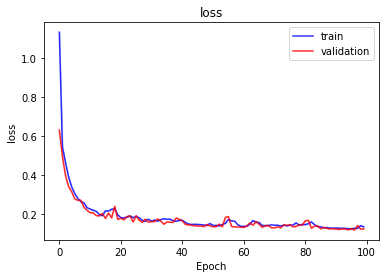

<b>bioma_loss</b>: 0.0287 (min: 0.0287, max: 0.0287)

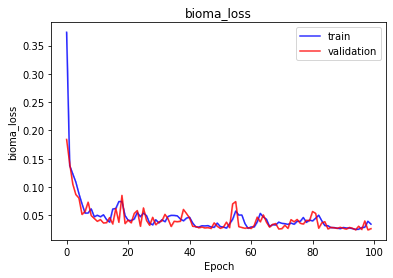

<b>domain_loss</b>: 0.0834 (min: 0.0834, max: 0.0834)

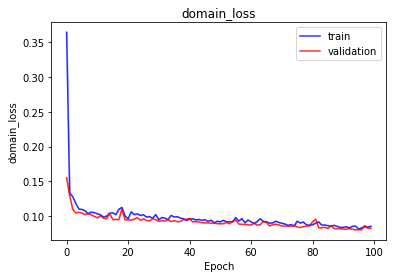

<b>latent_loss</b>: 0.0143 (min: 0.0143, max: 0.0143)

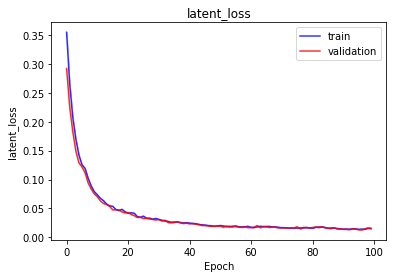

<b>bioma_mse</b>: 0.0002 (min: 0.0002, max: 0.0002)

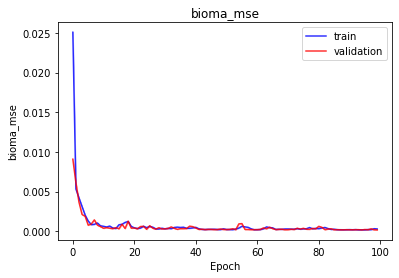

<b>bioma_mae</b>: 0.0064 (min: 0.0064, max: 0.0064)

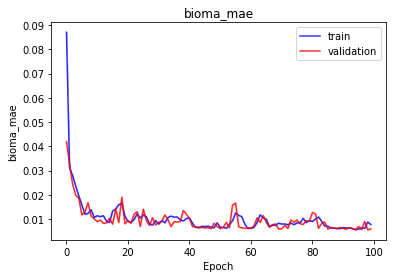

<b>bioma_mape</b>: 2542.6741 (min: 2542.6741, max: 2542.6741)

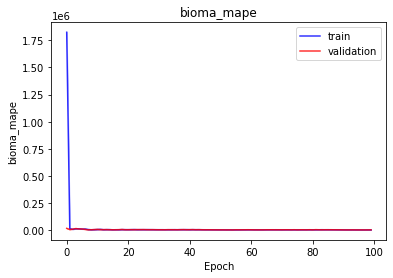

<b>bioma_BrayCurtis</b>: 0.0287 (min: 0.0287, max: 0.0287)

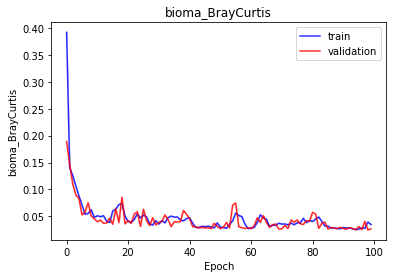

<b>bioma_pearson_corr</b>: 0.9976 (min: 0.9976, max: 0.9976)

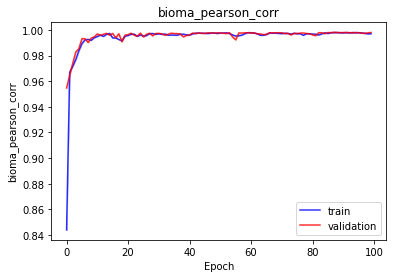

<b>bioma_jensen_shannon_divergence</b>: 0.0236 (min: 0.0236, max: 0.0236)

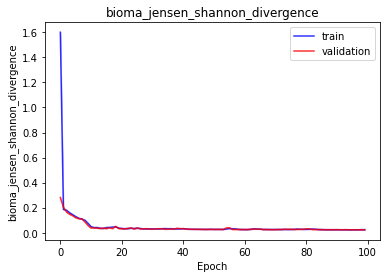

<b>domain_mse</b>: 0.0027 (min: 0.0027, max: 0.0027)

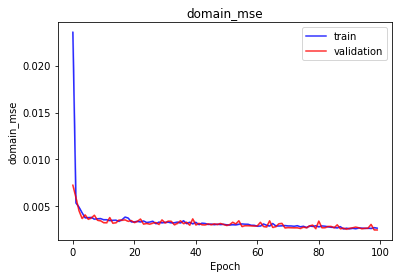

<b>domain_mae</b>: 0.0187 (min: 0.0187, max: 0.0187)

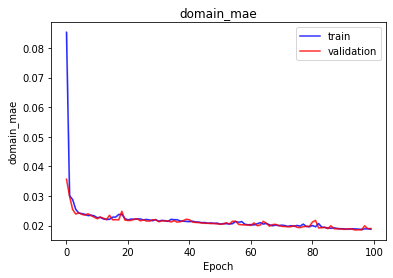

<b>domain_mape</b>: 2223.6248 (min: 2223.6248, max: 2223.6248)

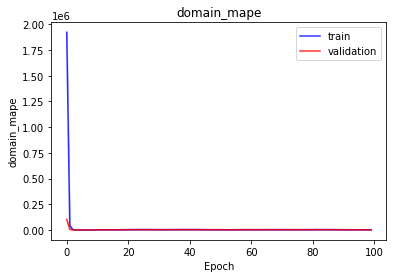

<b>domain_BrayCurtis</b>: 0.0842 (min: 0.0842, max: 0.0842)

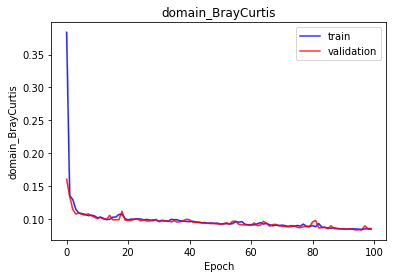

<b>domain_pearson_corr</b>: 0.9792 (min: 0.9792, max: 0.9792)

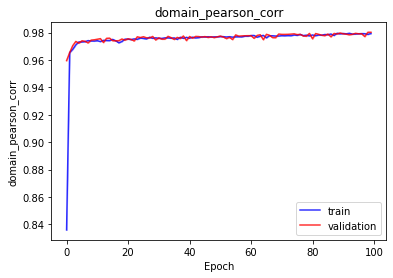

<b>domain_jensen_shannon_divergence</b>: 0.0687 (min: 0.0687, max: 0.0687)

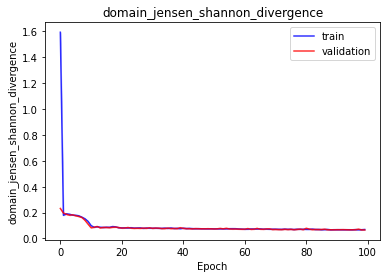

<b>latent_mae</b>: 0.0145 (min: 0.0145, max: 0.0145)

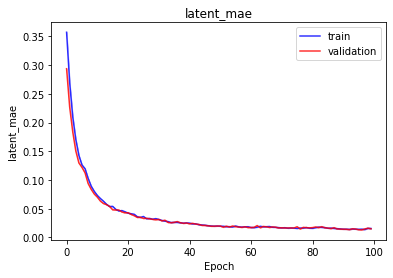

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.12735713343335014 | 0.12735713343335014 | 0.12735713343335014 |
| bioma_loss | 0.028749117627739906 | 0.028749117627739906 | 0.028749117627739906 |
| domain_loss | 0.08342698961496353 | 0.08342698961496353 | 0.08342698961496353 |
| latent_loss | 0.014341907575726509 | 0.014341907575726509 | 0.014341907575726509 |
| bioma_mse | 0.00022971973521634936 | 0.00022971973521634936 | 0.00022971973521634936 |
| bioma_mae | 0.00637730211019516 | 0.00637730211019516 | 0.00637730211019516 |
| bioma_mape | 2542.674072265625 | 2542.674072265625 | 2542.674072265625 |
| bioma_BrayCurtis | 0.028697729110717773 | 0.028697729110717773 | 0.028697729110717773 |
| bioma_pearson_corr | 0.9975757598876953 | 0.9975757598876953 | 0.9975757598876953 |
| bioma_jensen_shannon_divergence | 0.023641688749194145 | 0.023641688749194145 | 0.023641688749194145 |
| domain_mse | 0.0026621653232723475 | 0.0026621653232723475 | 0.0026621653232723475 |
| domain_mae | 0.018700886517763138 | 0.018700886517763138 | 0.018700886517763138 |
| domain_mape | 2223.624755859375 | 2223.624755859375 | 2223.624755859375 |
| domain_BrayCurtis | 0.08415361493825912 | 0.08415361493825912 | 0.08415361493825912 |
| domain_pearson_corr | 0.9792078137397766 | 0.9792078137397766 | 0.9792078137397766 |
| domain_jensen_shannon_divergence | 0.06871367245912552 | 0.06871367245912552 | 0.06871367245912552 |
| latent_mae | 0.014505788683891296 | 0.014505788683891296 | 0.014505788683891296 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.12604200839996338 | 0.12604200839996338 | 0.12604200839996338 |
| pearson_corr | 0.964167594909668 | 0.964167594909668 | 0.964167594909668 |
| jensen_shannon_divergence | 0.10930219292640686 | 0.10930219292640686 | 0.10930219292640686 |


In [42]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='relu')(in_layer)
    net = layers.Dense(64, activation='relu')(net)
    net = layers.Dense(32, activation='relu')(net)
    net = layers.Dense(16, activation='relu')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

In [43]:
encoder_biome = encoder
encoder_domain = model_latent
#Guardamos las predicciones
df_microbioma_test.T.to_csv('Results/comida/filo/otus_original_test_CombinedcomidaFiltrada_filo.tsv', index=True, header=True, sep='\t')

#run prediction test set from microbiome, i.e, reconstructed
# Input only domain (i.e. environmental features)
pred_latent_biome = encoder_biome.predict(data_microbioma_test)
pred_biome = decoder.predict(pred_latent_biome)

_, _ = save_predicted_otu_table_and_latent(pred_biome,pred_latent_biome,df_microbioma_test.index,df_microbioma_test.columns,'reconstAEfromBiome_CombinedcomidaFiltrada_filo')

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_domain_test)
pred_domain = decoder.predict(pred_latent)
df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,df_microbioma_test.index,df_microbioma_test.columns,'predFromDomain_CombinedcomidaFiltrada_filo')

#--------------------
actual_array = transform_to_rel_abundance(data_microbioma_test)
RSE_perOTU, RRSE_perOTU  = compute_relative_squared_error(actual_array,pred_domain)

df_error_perOTU = save_errors_per_OTU(RSE_perOTU,RRSE_perOTU,df_microbioma_test.columns,'Results/comida/filo/errors_perOTU_CombinedcomidaFiltrada_filo')

In [44]:
metrics = FI()
tabla_FI = pd.DataFrame.from_dict(metrics)
tabla_FI.to_csv("Results/comida/FI/FI_Combined_filo_comidaFiltrada.csv",index=False)